In [1]:
import pandas as pd
import numpy as np
from skimpy import skim
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, average_precision_score

In [2]:
df_train = pd.read_csv("../data/train.csv")

In [3]:
df_test = pd.read_csv("../data/test.csv")

In [4]:
df_train.head()

,loan_amnt,term (months),int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,zip_code
0,7000.0,36,8.99,222.57,B1,RENT,154000.0,Source Verified,Fully Paid,credit_card,23.88,16,0,91725.0,62.2,48,INDIVIDUAL,2.0,5113
1,2000.0,36,11.53,65.99,B5,RENT,41600.0,Not Verified,Fully Paid,debt_consolidation,26.49,11,0,3541.0,20.1,16,INDIVIDUAL,0.0,22690
2,24000.0,60,12.39,538.61,C1,MORTGAGE,120000.0,Source Verified,Fully Paid,debt_consolidation,19.01,13,0,38065.0,79.0,34,INDIVIDUAL,1.0,48052
3,15575.0,60,17.57,391.87,D2,MORTGAGE,62000.0,Source Verified,Charged Off,debt_consolidation,26.06,9,0,15089.0,74.7,23,INDIVIDUAL,5.0,48052
4,12000.0,36,12.69,402.54,C2,RENT,36000.0,Source Verified,Charged Off,debt_consolidation,34.67,18,0,5681.0,38.6,28,INDIVIDUAL,0.0,86630


### Converting categorical data to numeric features

In [5]:
columns_to_encode = ['home_ownership','verification_status','purpose','application_type','sub_grade']

In [6]:
# One-hot encoding 
df_train = pd.get_dummies(df_train, columns=columns_to_encode)
df_test = pd.get_dummies(df_test, columns=columns_to_encode)

In [7]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
df_train['Label'] = df_train[target_column].map(class_mapping)
df_test['Label'] = df_test[target_column].map(class_mapping)

In [8]:
print(df_train.shape)
print(df_train['Label'].value_counts(normalize=True) * 100)
print(df_test.shape)
print(df_test['Label'].value_counts(normalize=True) * 100)

(223591, 73)
Label
0    80.224159
1    19.775841
Name: proportion, dtype: float64
(112456, 74)
Label
0    80.279398
1    19.720602
Name: proportion, dtype: float64


In [9]:
df_train['purpose_educational'] = False


In [10]:
train_columns = df_train.columns
test_columns = df_test.columns

if set(train_columns) == set(test_columns):
    print("All columns match.")
else:
    print("Columns do not match.")


All columns match.


In [11]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,...,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,Label
0,1300.0,36,15.61,45.46,34000.0,Fully Paid,30.39,8,0,10457.0,...,False,False,False,False,False,False,False,False,False,0
1,12000.0,36,11.14,393.67,46000.0,Fully Paid,16.72,17,0,16104.0,...,False,False,False,False,False,False,False,False,False,0
2,13200.0,36,12.85,443.81,85000.0,Fully Paid,6.89,11,0,17325.0,...,False,False,False,False,False,False,False,False,False,0
3,15000.0,36,17.77,540.56,55000.0,Fully Paid,21.27,10,0,34191.0,...,False,False,False,False,False,False,False,False,False,0
4,7400.0,36,10.15,239.30,54000.0,Fully Paid,10.02,19,0,8232.0,...,False,False,False,False,False,False,False,False,False,0


In [12]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [13]:
X_train = df_train.drop(['Label','loan_status'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label','loan_status'], axis=1)
y_test = df_test['Label']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Basic, Basic tuning, Balanced tuning

### Random Forest Model

In [37]:
rf_base = RandomForestClassifier(random_state=42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_pred_base = rf_base.predict(X_test)

y_probs = rf_base.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred_base, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.999983      1.000000  0.999987       0.999992       0.999987
recall          1.000000      0.999932  0.999987       0.999966       0.999987
f1-score        0.999992      0.999966  0.999987       0.999979       0.999987
support    179374.000000  44217.000000  0.999987  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[179374      0]
 [     3  44214]]

Test Result:
Accuracy Score: 88.43%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.878731      0.938379  0.884275       0.908555       0.890494
recall         0.992867      0.442215  0.884275       0.717541       0.884275
f1-score       0.932319      0.601140  0.884275       0.766729       0.867008
support    90279.000000  22177.000000  0.884275  112456.000000 

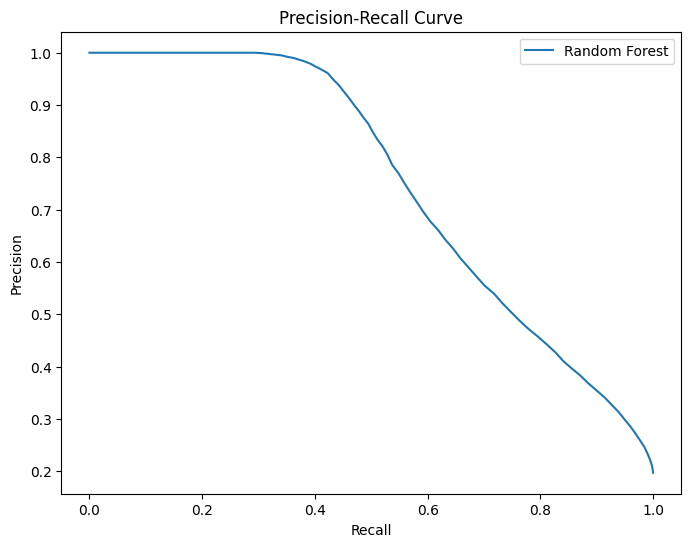

In [38]:
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [39]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.4350814654507198

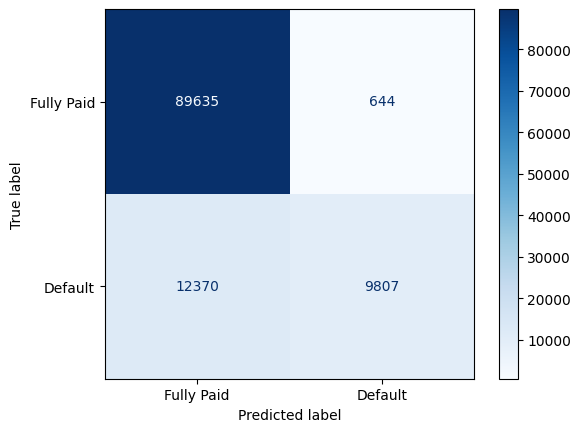

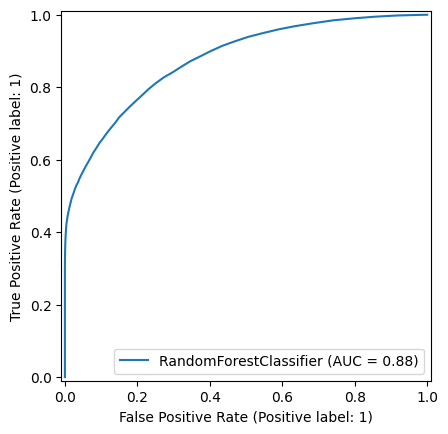

In [44]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(rf_base, X_test, y_test)

In [87]:
auprc_base = average_precision_score(y_test, y_probs)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")


Area Under the Precision-Recall Curve (AUPRC): 0.7456


In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 400, 600],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Added class_weight parameter
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1_weighted')

random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None, 'bootstrap': False}
Best Score: 0.8662064742211784


In [ ]:
y_train_pred_rc = random_search.predict(X_train)
y_pred_base_rc = random_search.predict(X_test)
y_probs_rc = random_search.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc, train=True)
print_score(y_test, y_pred_base_rc, train=False)

Train Result:
Accuracy Score: 99.58%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.994798      1.000000  0.995805       0.997399       0.995827
recall          1.000000      0.978786  0.995805       0.989393       0.995805
f1-score        0.997392      0.989280  0.995805       0.993336       0.995788
support    179374.000000  44217.000000  0.995805  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[179374      0]
 [   938  43279]]

Test Result:
Accuracy Score: 88.49%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.878545      0.948267  0.884933       0.913406       0.892295
recall         0.994096      0.440547  0.884933       0.717321       0.884933
f1-score       0.932755      0.601601  0.884933       0.767178       0.867450
support    90279.000000  22177.000000  0.884933  112456.000000  

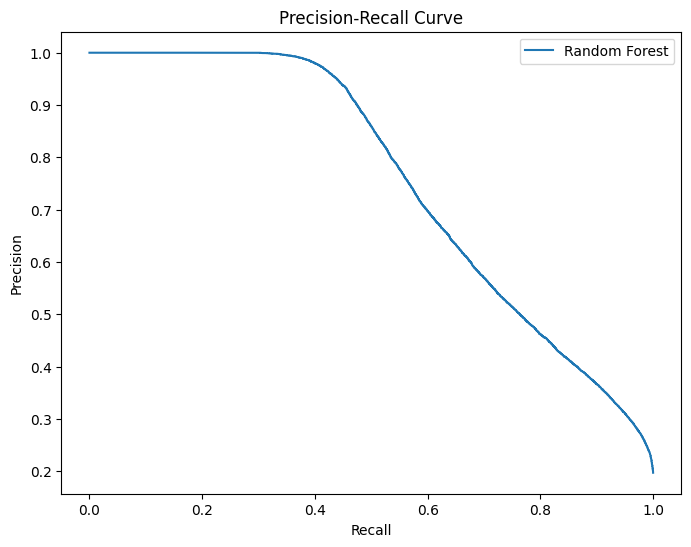

In [74]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

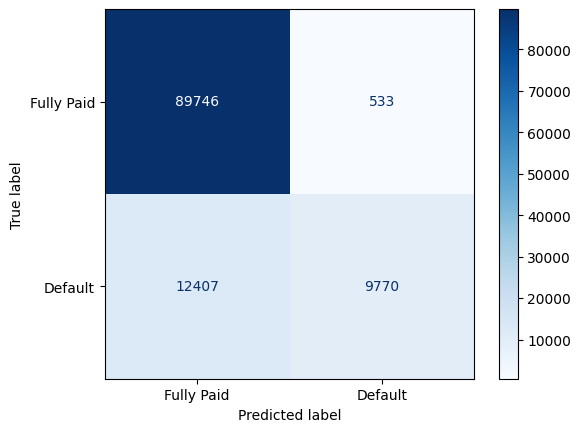

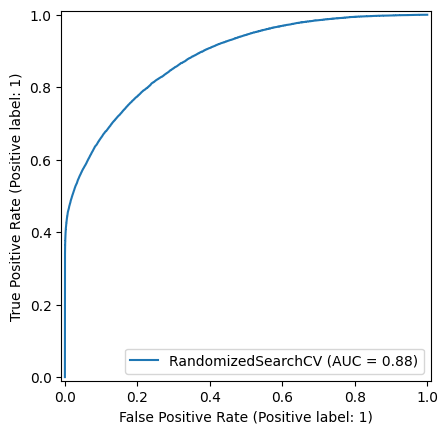

In [75]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)

In [76]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_rc)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.43464259208222455

In [89]:
auprc_base = average_precision_score(y_test, y_probs_rc)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7568


### using AUC precision recall as metric

In [97]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 400, 600],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Added class_weight parameter
}

auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

rf = RandomForestClassifier(random_state=42)

random_search_auc = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring=auprc_scorer)

random_search_auc.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_auc.best_params_)
print("Best Score:", random_search_auc.best_score_)

Best Parameters: {'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}
Best Score: 0.7774536474494619


In [98]:
y_train_pred_rc_auc = random_search_auc.predict(X_train)
y_pred_base_rc_auc = random_search_auc.predict(X_test)
y_probs_rc_auc = random_search_auc.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_auc, train=True)
print_score(y_test, y_pred_base_rc_auc, train=False)

Train Result:
Accuracy Score: 80.97%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.943572      0.512024  0.809702       0.727798       0.858230
recall          0.811310      0.803175  0.809702       0.807243       0.809702
f1-score        0.872457      0.625373  0.809702       0.748915       0.823594
support    179374.000000  44217.000000  0.809702  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[145528  33846]
 [  8703  35514]]

Test Result:
Accuracy Score: 80.48%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.939103      0.503246  0.804795       0.721175       0.853149
recall         0.809324      0.786355  0.804795       0.797840       0.804795
f1-score       0.869397      0.613725  0.804795       0.741561       0.818977
support    90279.000000  22177.000000  0.804795  112456.000000  

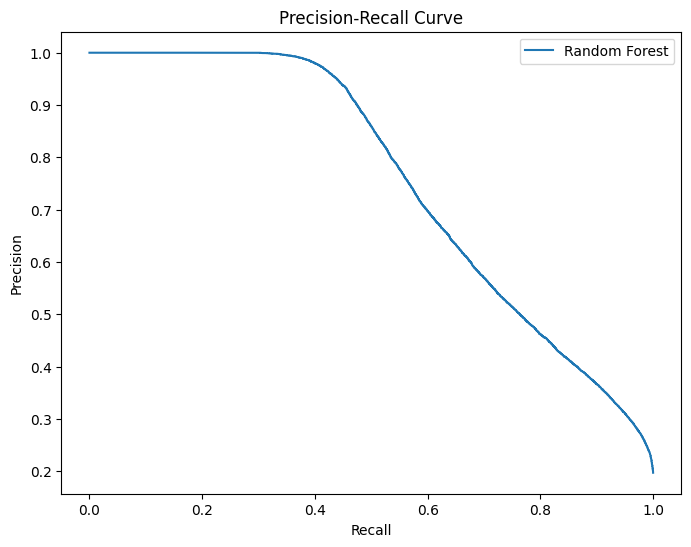

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

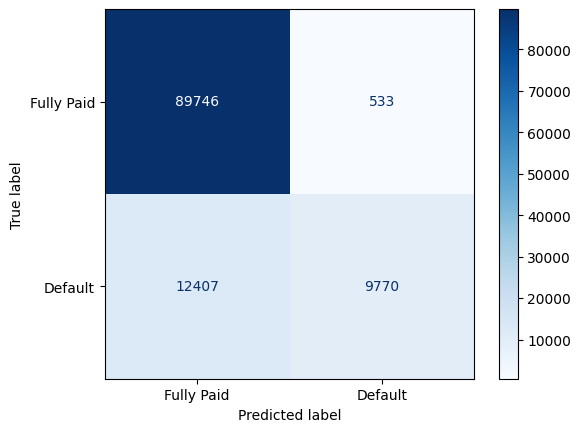

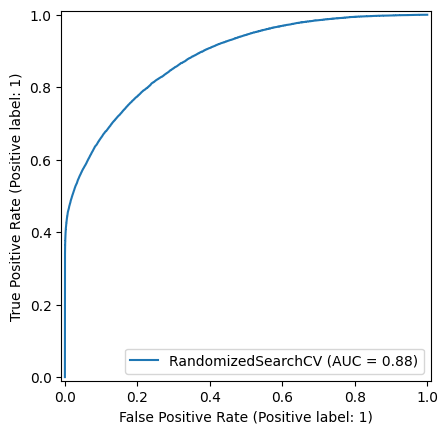

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)

In [ ]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_rc)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.43464259208222455

In [ ]:
auprc_base = average_precision_score(y_test, y_probs_rc)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7568


mm i set to class_weight = balanced now only for tuning

In [77]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 400, 600],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier(random_state=42, class_weight = "balanced")

random_search_balanced_rc = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1_weighted')

random_search_balanced_rc.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_balanced_rc.best_params_)
print("Best Score:", random_search_balanced_rc.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.5, 'max_depth': None, 'bootstrap': True}
Best Score: 0.8678647014391093


In [78]:
y_train_pred_rc_balanced = random_search_balanced_rc.predict(X_train)
y_pred_base_rc_balanced = random_search_balanced_rc.predict(X_test)
y_probs_rc_balanced = random_search_balanced_rc.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_balanced, train=True)
print_score(y_test, y_pred_base_rc_balanced, train=False)

Train Result:
Accuracy Score: 96.99%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.986578      0.905678  0.969865       0.946128       0.970580
recall          0.975710      0.946152  0.969865       0.960931       0.969865
f1-score        0.981114      0.925473  0.969865       0.953293       0.970110
support    179374.000000  44217.000000  0.969865  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[175017   4357]
 [  2381  41836]]

Test Result:
Accuracy Score: 86.96%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.908039      0.689801   0.86962       0.798920       0.865001
recall         0.931978      0.615773   0.86962       0.773875       0.869620
f1-score       0.919853      0.650689   0.86962       0.785271       0.866772
support    90279.000000  22177.000000   0.86962  112456.000000  

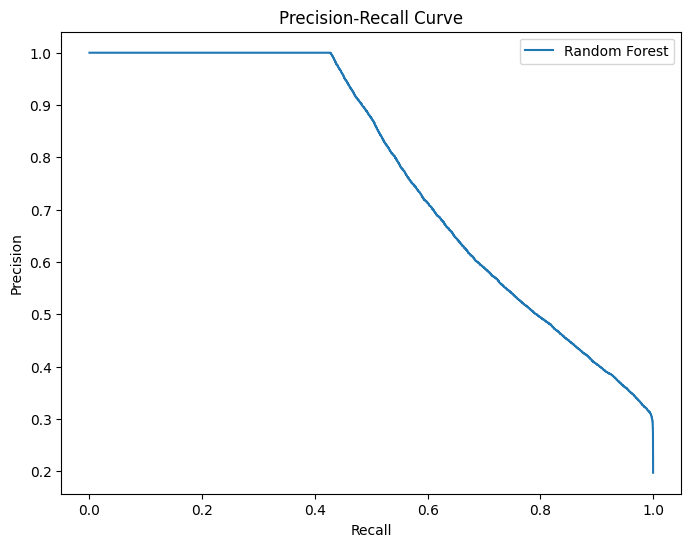

In [79]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_balanced)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

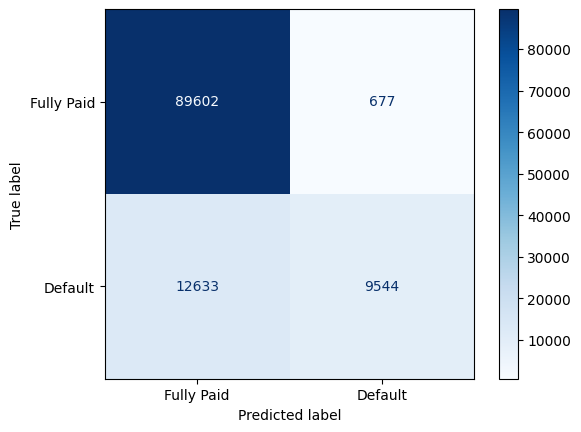

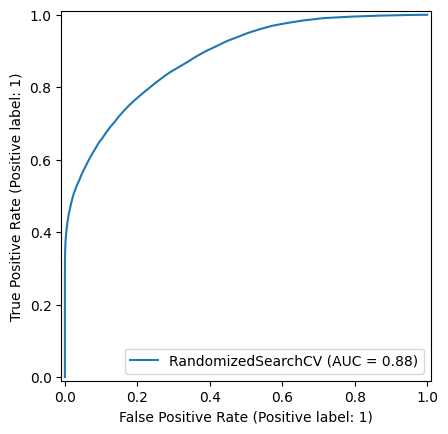

In [49]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)

In [80]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_rc_balanced)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.5477506345590728

In [88]:
auprc_base = average_precision_score(y_test, y_probs_rc_balanced)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7737


# Undersampled 

In [14]:
rus = RandomUnderSampler(random_state=42)

In [15]:
X_under, y_under = rus.fit_resample(X_train, y_train)

In [16]:
print(X_under.shape)
print(y_under.shape)

(88434, 72)
(88434,)


In [17]:
print('Fully Paid:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Charged Off:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Fully Paid: 44217 / 50.0 % of the dataset
Charged Off: 44217 / 50.0 % of the dataset


In [18]:
base_rf = RandomForestClassifier(random_state=42)

In [19]:
pipeline = Pipeline([
    ('undersample', rus),
    ('classifier', base_rf)
])

In [56]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersample', RandomUnderSampler(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [57]:
y_train_pred_under = pipeline.predict(X_train)
y_pred_base_under = pipeline.predict(X_test)

y_probs_unnder = pipeline.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_under, train=True)
print_score(y_test, y_pred_base_under, train=False)

Train Result:
Accuracy Score: 87.20%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       1.000000      0.607135  0.872034       0.803567       0.922308
recall          0.840490      1.000000  0.872034       0.920245       0.872034
f1-score        0.913333      0.755549  0.872034       0.834441       0.882130
support    179374.000000  44217.000000  0.872034  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[150762  28612]
 [     0  44217]]

Test Result:
Accuracy Score: 78.72%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.935270      0.475736  0.787152       0.705503       0.844647
recall         0.789508      0.777562  0.787152       0.783535       0.787152
f1-score       0.856230      0.590305  0.787152       0.723268       0.803788
support    90279.000000  22177.000000  0.787152  112456.000000  

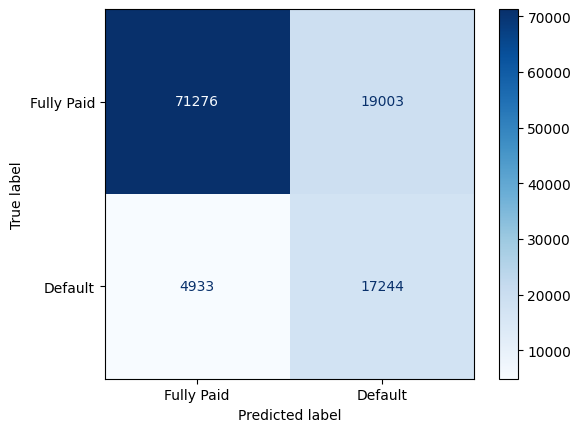

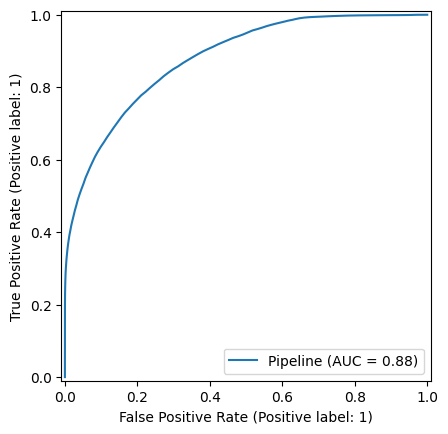

In [58]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

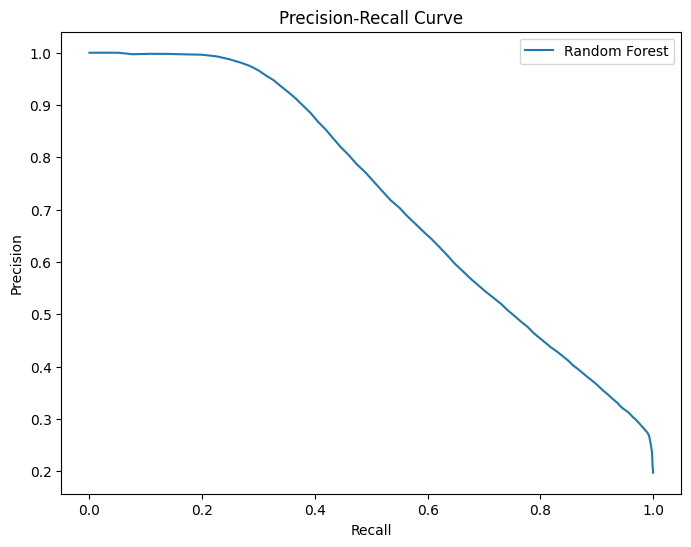

In [59]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_unnder)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [91]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.5670704198665858

In [92]:
auprc_base = average_precision_score(y_test, y_probs_unnder)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7203


### model tuning

In [66]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 400, 600],
    'classifier__max_depth': [None, 5, 10, 15, 20, 30],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
    'classifier__max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'classifier__bootstrap': [True, False]
}


random_search_under = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1')

random_search_under.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_under.best_params_)
print("Best Score:", random_search_under.best_score_)

Best Parameters: {'classifier__n_estimators': 50, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 0.5, 'classifier__max_depth': 10, 'classifier__bootstrap': False}
Best Score: 0.6169523840849555


In [67]:
y_train_pred_rc_under = random_search_under.predict(X_train)
y_pred_base_rc_under = random_search_under.predict(X_test)
y_probs_rc_under = random_search_under.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_under, train=True)
print_score(y_test, y_pred_base_rc_under, train=False)

Train Result:
Accuracy Score: 80.81%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.943068      0.509339  0.808056       0.726204       0.857295
recall          0.809616      0.801728  0.808056       0.805672       0.808056
f1-score        0.871261      0.622930  0.808056       0.747096       0.822152
support    179374.000000  44217.000000  0.808056  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[145224  34150]
 [  8767  35450]]

Test Result:
Accuracy Score: 80.34%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.938844      0.500977  0.803399       0.719911       0.852494
recall         0.807718      0.785814  0.803399       0.796766       0.803399
f1-score       0.868359      0.611871  0.803399       0.740115       0.817778
support    90279.000000  22177.000000  0.803399  112456.000000  

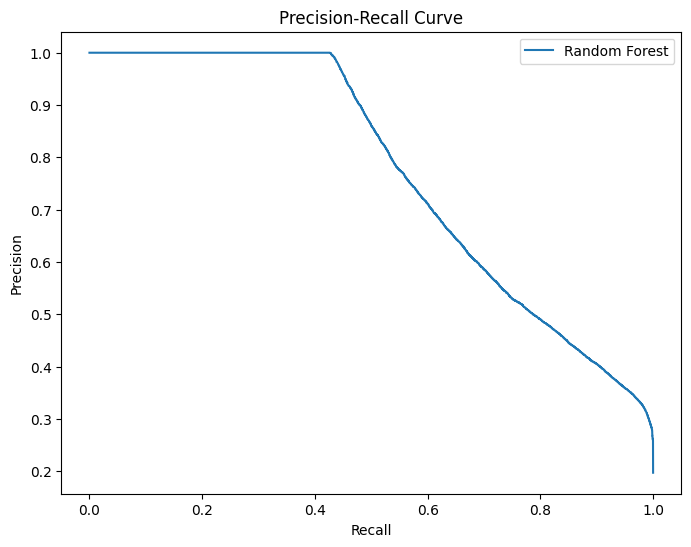

In [68]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_under)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

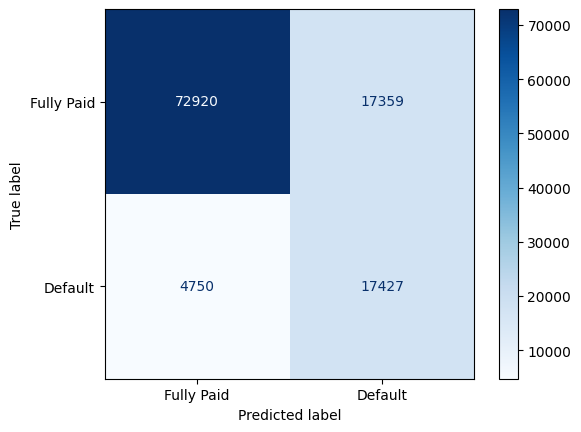

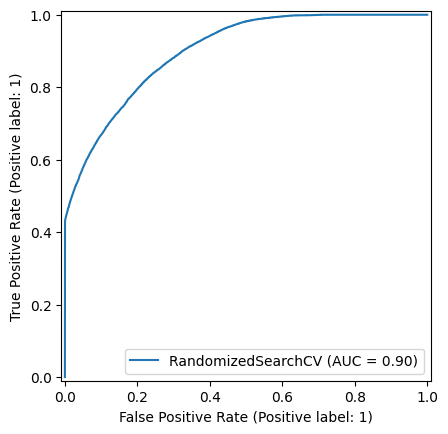

In [69]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search_under, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search_under, X_test, y_test)

In [70]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_rc_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.5935324272642809

In [93]:
auprc_base = average_precision_score(y_test, y_probs_rc_under)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7713


### tuning with AUC of precision recall

In [24]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 400, 600],
    'classifier__max_depth': [None, 5, 10, 15, 20, 30],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
    'classifier__max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'classifier__bootstrap': [True, False]
}

auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

random_search_under_auc = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring=auprc_scorer)

random_search_under_auc.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_under_auc.best_params_)
print("Best Score:", random_search_under_auc.best_score_)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 15, 'classifier__min_samples_leaf': 6, 'classifier__max_features': 0.7, 'classifier__max_depth': 20, 'classifier__bootstrap': True}
Best Score: 0.7768705684177336


In [25]:
y_train_pred_rc_auc_under = random_search_under_auc.predict(X_train)
y_pred_base_rc_auc_under = random_search_under_auc.predict(X_test)
y_probs_rc_auc_under = random_search_under_auc.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_auc_under, train=True)
print_score(y_test, y_pred_base_rc_auc_under, train=False)

Train Result:
Accuracy Score: 84.58%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.976920      0.567907  0.845785       0.772414       0.896034
recall          0.827316      0.920709  0.845785       0.874013       0.845785
f1-score        0.895916      0.702501  0.845785       0.799208       0.857666
support    179374.000000  44217.000000  0.845785  223591.000000  223591.000000
_________________
Confusion Matrix: 
 [[148399  30975]
 [  3506  40711]]

Test Result:
Accuracy Score: 80.03%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.942899      0.496099  0.800304       0.719499       0.854787
recall         0.799677      0.802859  0.800304       0.801268       0.800304
f1-score       0.865402      0.613257  0.800304       0.739330       0.815678
support    90279.000000  22177.000000  0.800304  112456.000000  

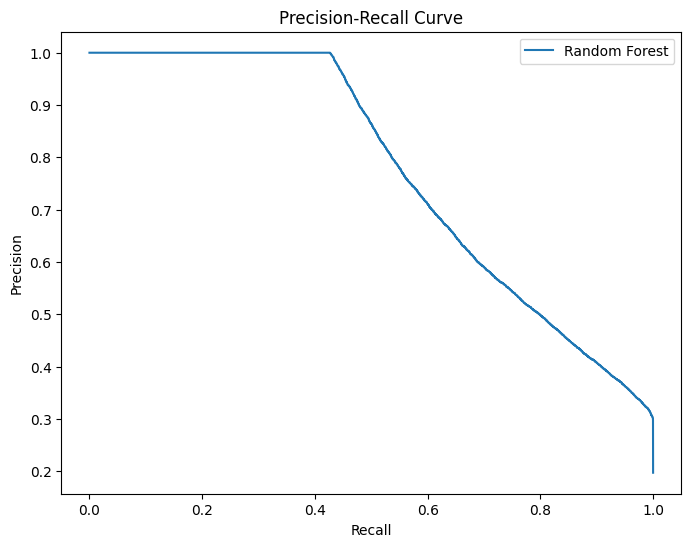

In [26]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_auc_under)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

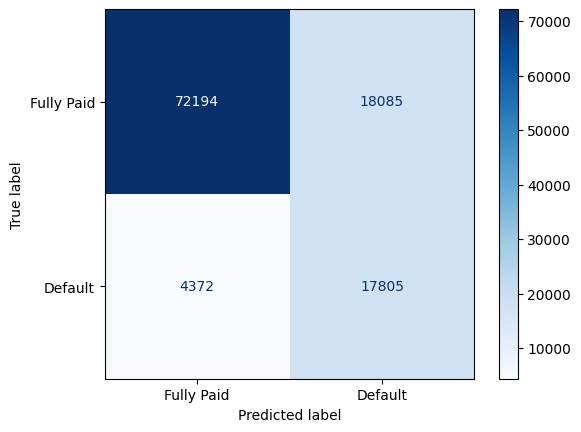

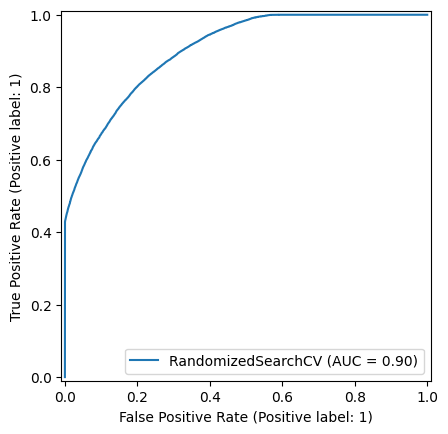

In [27]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search_under_auc, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search_under_auc, X_test, y_test)

In [28]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_rc_auc_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.6025353759190653

In [29]:
auprc_base = average_precision_score(y_test, y_probs_rc_auc_under)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")

Area Under the Precision-Recall Curve (AUPRC): 0.7735


# Full cleaned data, one hot encoding, class_weight = None

In [30]:
df = pd.read_csv("../data/cleaned_data.csv", encoding = "ISO-8859-1")

### Converting categorical data to numeric features

In [28]:
columns_to_encode = ['home_ownership','verification_status','purpose','addr_state','application_type','sub_grade','initial_list_status']

In [29]:
# One-hot encoding 
df = pd.get_dummies(df, columns=columns_to_encode)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220092 entries, 0 to 1220091
Columns: 130 entries, loan_amnt to initial_list_status_Whole Funded
dtypes: bool(111), float64(10), int64(7), object(2)
memory usage: 306.0+ MB


In [31]:
print(df['loan_status'].value_counts())


loan_status
Fully Paid     979419
Charged Off    240673
Name: count, dtype: int64


### Train/Test Split

In [32]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_1740\3004380484.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


In [33]:
unique_issue_dates = df['issue_d'].unique()
sorted_unique_issue_dates = pd.Series(unique_issue_dates).sort_values()
print(sorted_unique_issue_dates)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


In [34]:
df_train = df.loc[df['issue_d'] <  df['issue_d'].quantile(0.9)]
df_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.9)]

In [35]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
df_train['Label'] = df_train[target_column].map(class_mapping)
df_test['Label'] = df_test[target_column].map(class_mapping)

C:\Users\winyan\AppData\Local\Temp\ipykernel_1740\1921503662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Label'] = df_train[target_column].map(class_mapping)
C:\Users\winyan\AppData\Local\Temp\ipykernel_1740\1921503662.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Label'] = df_test[target_column].map(class_mapping)


In [36]:
print(df_train.shape)
print(df_train['Label'].value_counts(normalize=True) * 100)
print(df_test.shape)
print(df_test['Label'].value_counts(normalize=True) * 100)

(1096951, 131)
Label
0    80.205497
1    19.794503
Name: proportion, dtype: float64
(123141, 131)
Label
0    80.886139
1    19.113861
Name: proportion, dtype: float64


In [37]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,emp_length,annual_inc,issue_d,loan_status,dti,earliest_cr_line,...,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,initial_list_status_Fractional Funded,initial_list_status_Whole Funded,Label
353336,3000.0,36,7.34,93.10,9.0,52000.0,2018-03-01,Fully Paid,0.58,1998,...,False,False,False,False,False,False,False,False,True,0
353337,5000.0,36,11.98,166.03,10.0,55000.0,2018-03-01,Fully Paid,14.18,2001,...,False,False,False,False,False,False,False,False,True,0
353338,7000.0,36,11.98,232.44,0.0,40000.0,2018-03-01,Fully Paid,20.25,2007,...,False,False,False,False,False,False,False,False,True,0
353339,30000.0,36,21.85,1143.39,10.0,57000.0,2018-03-01,Fully Paid,27.58,2000,...,False,False,False,False,False,False,False,False,True,0
353340,21000.0,60,20.39,560.94,10.0,85000.0,2018-03-01,Fully Paid,15.76,2008,...,False,False,False,False,False,False,False,False,True,0


### Random Forest Model

In [38]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [39]:
X_train = df_train.drop(['Label', 'issue_d','loan_status'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label', 'issue_d','loan_status'], axis=1)
y_test = df_test['Label']

In [40]:
rf_base = RandomForestClassifier(random_state=42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_pred_base = rf_base.predict(X_test)

y_probs = rf_base.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred_base, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.999977       1.000000  0.999982  9.999886e-01  9.999818e-01
recall          1.000000       0.999908  0.999982  9.999539e-01  9.999818e-01
f1-score        0.999989       0.999954  0.999982  9.999713e-01  9.999818e-01
support    879815.000000  217136.000000  0.999982  1.096951e+06  1.096951e+06
_________________
Confusion Matrix: 
 [[879815      0]
 [    20 217116]]

Test Result:
Accuracy Score: 80.81%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.819340      0.488317  0.808066       0.653828       0.756068
recall         0.978455      0.087012  0.808066       0.532733       0.808066
f1-score       0.891856      0.147705  0.808066       0.519780       0.749620
support    99604.000000  23537.000000  0.808066  123141.000000  1231

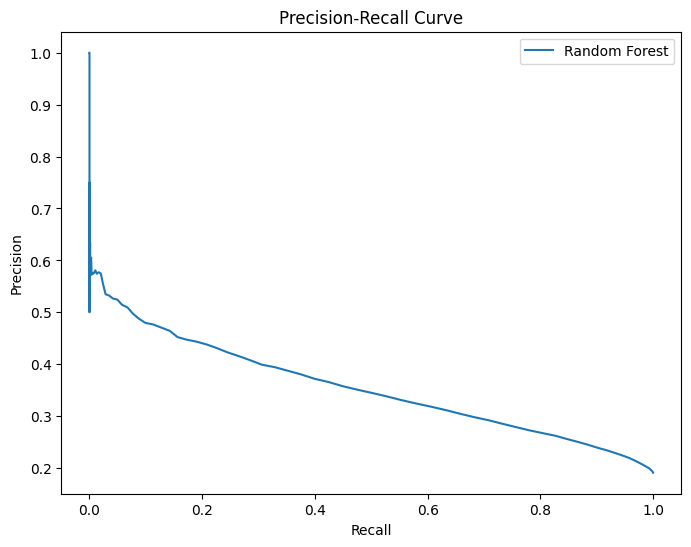

In [41]:
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [42]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.06546661918470373

In [43]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1_weighted')

random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Best Score: 0.738459023736674


In [44]:
y_train_pred_rc = random_search.predict(X_train)
y_pred_base_rc = random_search.predict(X_test)
y_probs_rc = random_search.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc, train=True)
print_score(y_test, y_pred_base_rc, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.999977       1.000000  0.999982  9.999886e-01  9.999818e-01
recall          1.000000       0.999908  0.999982  9.999539e-01  9.999818e-01
f1-score        0.999989       0.999954  0.999982  9.999713e-01  9.999818e-01
support    879815.000000  217136.000000  0.999982  1.096951e+06  1.096951e+06
_________________
Confusion Matrix: 
 [[879815      0]
 [    20 217116]]

Test Result:
Accuracy Score: 80.81%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.819340      0.488317  0.808066       0.653828       0.756068
recall         0.978455      0.087012  0.808066       0.532733       0.808066
f1-score       0.891856      0.147705  0.808066       0.519780       0.749620
support    99604.000000  23537.000000  0.808066  123141.000000  1231

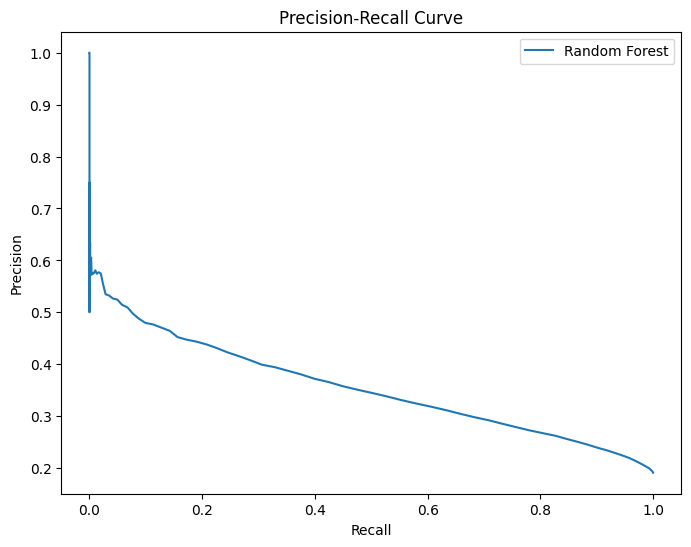

In [45]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

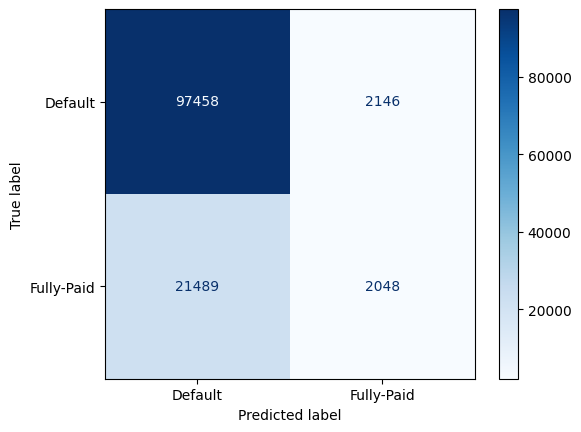

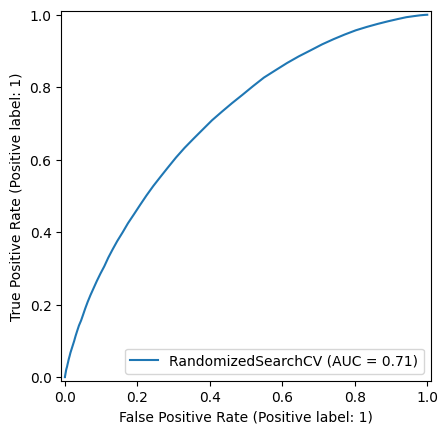

In [46]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)

# Full cleaned data, one hot encoding, class_weight = balanced & balanced_subsample

In [4]:
df = pd.read_csv("../data/cleaned_data.csv", encoding = "ISO-8859-1")

### Converting categorical data to numeric features

In [5]:
columns_to_encode = ['home_ownership','verification_status','purpose','addr_state','application_type','sub_grade','initial_list_status']

In [6]:
# One-hot encoding 
df = pd.get_dummies(df, columns=columns_to_encode)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220092 entries, 0 to 1220091
Columns: 130 entries, loan_amnt to initial_list_status_Whole Funded
dtypes: bool(111), float64(10), int64(7), object(2)
memory usage: 306.0+ MB


In [8]:
print(df['loan_status'].value_counts())


loan_status
Fully Paid     979419
Charged Off    240673
Name: count, dtype: int64


### Train/Test Split

In [9]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_11208\3004380484.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


In [10]:
unique_issue_dates = df['issue_d'].unique()
sorted_unique_issue_dates = pd.Series(unique_issue_dates).sort_values()
print(sorted_unique_issue_dates)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


In [11]:
df_train = df.loc[df['issue_d'] <  df['issue_d'].quantile(0.9)]
df_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.9)]

In [12]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
df_train['Label'] = df_train[target_column].map(class_mapping)
df_test['Label'] = df_test[target_column].map(class_mapping)

C:\Users\winyan\AppData\Local\Temp\ipykernel_11208\1921503662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Label'] = df_train[target_column].map(class_mapping)
C:\Users\winyan\AppData\Local\Temp\ipykernel_11208\1921503662.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Label'] = df_test[target_column].map(class_mapping)


In [13]:
print(df_train.shape)
print(df_train['Label'].value_counts(normalize=True) * 100)
print(df_test.shape)
print(df_test['Label'].value_counts(normalize=True) * 100)

(1096951, 131)
Label
0    80.205497
1    19.794503
Name: proportion, dtype: float64
(123141, 131)
Label
0    80.886139
1    19.113861
Name: proportion, dtype: float64


In [14]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,emp_length,annual_inc,issue_d,loan_status,dti,earliest_cr_line,...,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,initial_list_status_Fractional Funded,initial_list_status_Whole Funded,Label
353336,3000.0,36,7.34,93.10,9.0,52000.0,2018-03-01,Fully Paid,0.58,1998,...,False,False,False,False,False,False,False,False,True,0
353337,5000.0,36,11.98,166.03,10.0,55000.0,2018-03-01,Fully Paid,14.18,2001,...,False,False,False,False,False,False,False,False,True,0
353338,7000.0,36,11.98,232.44,0.0,40000.0,2018-03-01,Fully Paid,20.25,2007,...,False,False,False,False,False,False,False,False,True,0
353339,30000.0,36,21.85,1143.39,10.0,57000.0,2018-03-01,Fully Paid,27.58,2000,...,False,False,False,False,False,False,False,False,True,0
353340,21000.0,60,20.39,560.94,10.0,85000.0,2018-03-01,Fully Paid,15.76,2008,...,False,False,False,False,False,False,False,False,True,0


In [15]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print(f"F1 Weighted Score: {f1_score(true, pred, average='weighted') * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    else:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print(f"F1 Weighted Score: {f1_score(true, pred, average='weighted') * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [16]:
X_train = df_train.drop(['Label', 'issue_d','loan_status'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label', 'issue_d','loan_status'], axis=1)
y_test = df_test['Label']

### Random Forest Model

### with class_weight = balanced

In [53]:
rf_base_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_base_balanced.fit(X_train, y_train)

y_train_pred_balanced = rf_base_balanced.predict(X_train)
y_pred_base_balanced = rf_base_balanced.predict(X_test)

y_probs_balanced = rf_base_balanced.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_balanced, train=True)
print_score(y_test, y_pred_base_balanced, train=False)

Train Result:
Accuracy Score: 100.00%
F1 Weighted Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.999976       1.000000  0.999981  9.999881e-01  9.999809e-01
recall          1.000000       0.999903  0.999981  9.999516e-01  9.999809e-01
f1-score        0.999988       0.999952  0.999981  9.999699e-01  9.999809e-01
support    879815.000000  217136.000000  0.999981  1.096951e+06  1.096951e+06
_________________
Confusion Matrix: 
 [[879815      0]
 [    21 217115]]

Test Result:
Accuracy Score: 80.85%
F1 Weighted Score: 73.91%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.814574      0.489831   0.80848       0.652203       0.752503
recall         0.988163      0.048094   0.80848       0.518129       0.808480
f1-score       0.893011      0.087589   0.80848       0.490300       0.739064
support    9960

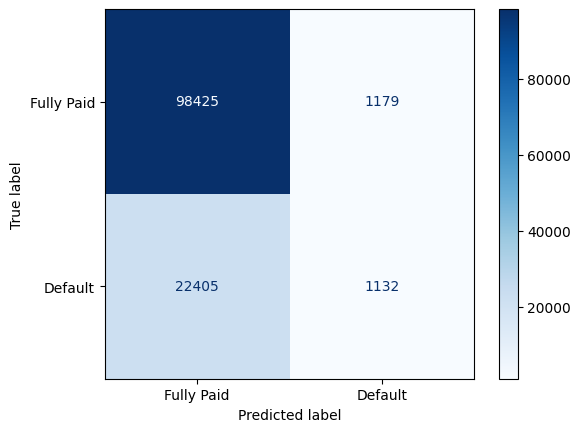

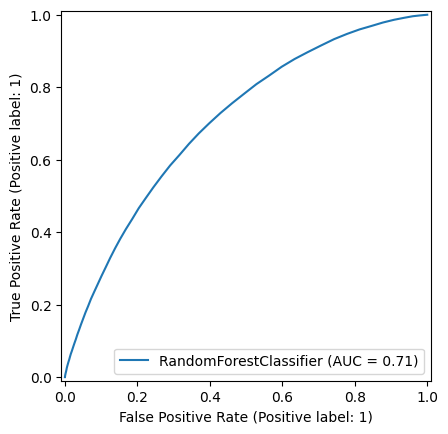

In [54]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base_balanced, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(rf_base_balanced, X_test, y_test)

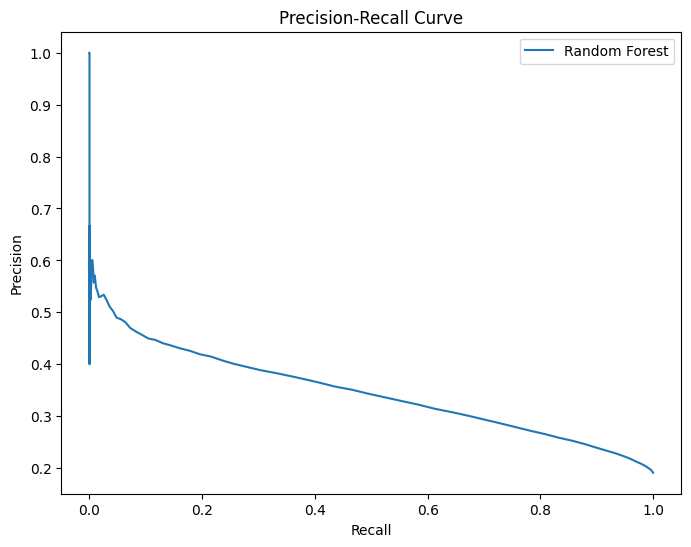

In [55]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_balanced)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [56]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_balanced)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.03625761550600385

In [57]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

rf_balanced = RandomForestClassifier(random_state=42, class_weight='balanced')

random_search_balanced = RandomizedSearchCV(estimator=rf_balanced,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1_weighted')

random_search_balanced.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_balanced.best_params_)
print("Best Score:", random_search_balanced.best_score_)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best Score: 0.750877573916004


In [58]:
y_train_pred_rc_balanced = random_search_balanced.predict(X_train)
y_pred_base_rc_balanced = random_search_balanced.predict(X_test)
y_probs_rc_balanced = random_search_balanced.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_balanced, train=True)
print_score(y_test, y_pred_base_rc_balanced, train=False)

Train Result:
Accuracy Score: 85.86%
F1 Weighted Score: 86.56%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.948033       0.607667  0.858622  7.778504e-01  8.806597e-01
recall          0.871501       0.806435  0.858622  8.389680e-01  8.586218e-01
f1-score        0.908158       0.693081  0.858622  8.006197e-01  8.655846e-01
support    879815.000000  217136.000000  0.858622  1.096951e+06  1.096951e+06
_________________
Confusion Matrix: 
 [[766760 113055]
 [ 42030 175106]]

Test Result:
Accuracy Score: 73.45%
F1 Weighted Score: 74.87%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.866607      0.356417  0.734508       0.611512       0.769090
recall         0.793984      0.482814  0.734508       0.638399       0.734508
f1-score       0.828708      0.410097  0.734508       0.619403       0.748695
support    99604.

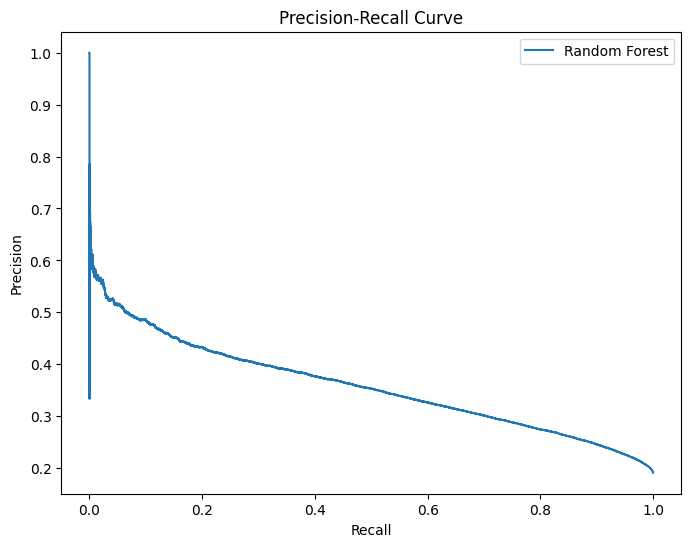

In [59]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_balanced)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

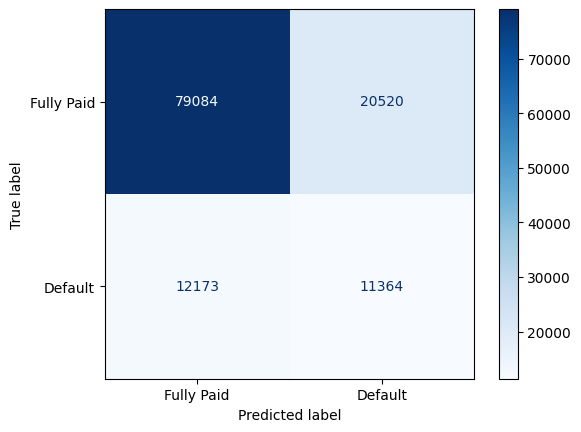

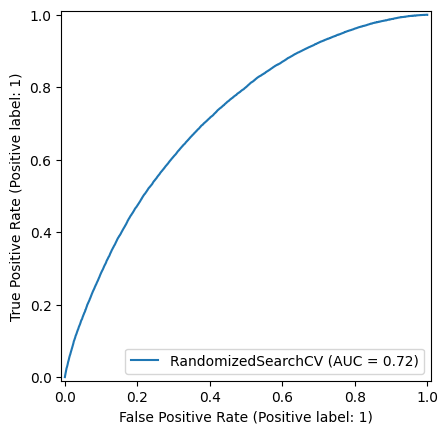

In [60]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search_balanced, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search_balanced, X_test, y_test)

### with class_weight = balanced_subsample

In [61]:
rf_base_balanced_subsample = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

rf_base_balanced_subsample.fit(X_train, y_train)

y_train_pred_balanced_subsample = rf_base_balanced_subsample.predict(X_train)
y_pred_base_balanced_subsample = rf_base_balanced_subsample.predict(X_test)

y_probs_balanced_subsample = rf_base_balanced_subsample.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_balanced_subsample, train=True)
print_score(y_test, y_pred_base_balanced_subsample, train=False)

Train Result:
Accuracy Score: 100.00%
F1 Weighted Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.999969       1.000000  0.999975  9.999847e-01  9.999754e-01
recall          1.000000       0.999876  0.999975  9.999378e-01  9.999754e-01
f1-score        0.999985       0.999938  0.999975  9.999612e-01  9.999754e-01
support    879815.000000  217136.000000  0.999975  1.096951e+06  1.096951e+06
_________________
Confusion Matrix: 
 [[879815      0]
 [    27 217109]]

Test Result:
Accuracy Score: 80.84%
F1 Weighted Score: 73.94%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.814701      0.488206  0.808407       0.651453       0.752295
recall         0.987802      0.049242  0.808407       0.518522       0.808407
f1-score       0.892940      0.089460  0.808407       0.491200       0.739364
support    9960

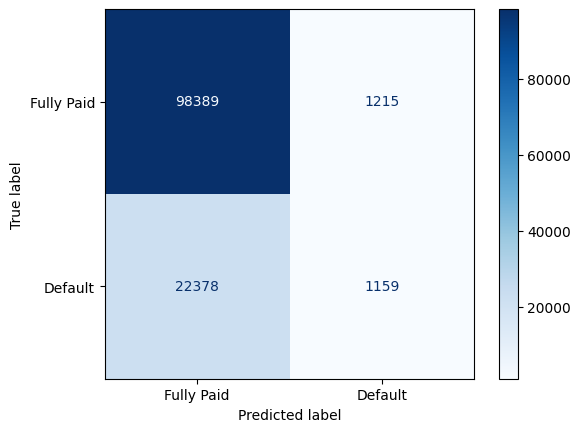

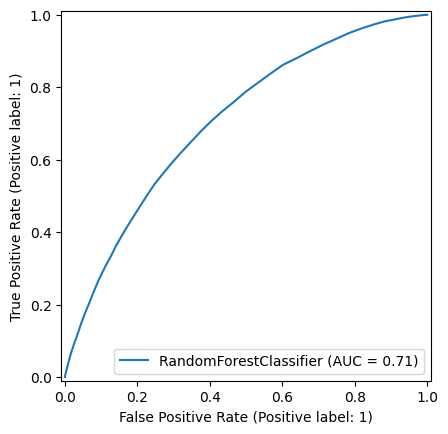

In [62]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base_balanced_subsample, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(rf_base_balanced_subsample, X_test, y_test)

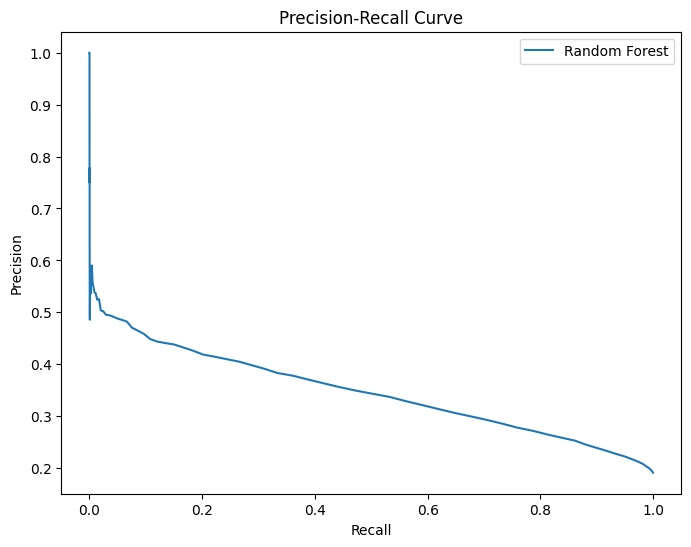

In [63]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_balanced_subsample)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [64]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_balanced_subsample)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.03704331428874198

In [65]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

rf_balanced_subsample = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

random_search_balanced_subsample = RandomizedSearchCV(estimator=rf_balanced_subsample,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1_weighted')

random_search_balanced_subsample.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_balanced_subsample.best_params_)
print("Best Score:", random_search_balanced_subsample.best_score_)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\winyan\AppD

Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}
Best Score: 0.7508462710667535


In [18]:
# Set the best parameters as found in your RandomizedSearchCV
best_params = {
    'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'log2',
    'max_depth': None,  # None means no limit
    'bootstrap': True,
    'class_weight': 'balanced_subsample',  # Since you used balanced_subsample in your search
    'random_state': 42
}

# Create a new model with the best parameters
rf_best_balanced_subsample = RandomForestClassifier(**best_params)

# Fit the model on your training data
rf_best_balanced_subsample.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', max_features='log2',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, random_state=42)

In [19]:
y_train_pred_rc_balanced_subsample = rf_best_balanced_subsample.predict(X_train)
y_pred_base_rc_balanced_subsample = rf_best_balanced_subsample.predict(X_test)
y_probs_rc_balanced_subsample = rf_best_balanced_subsample.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_balanced_subsample, train=True)
print_score(y_test, y_pred_base_rc_balanced_subsample, train=False)

Train Result:
Accuracy Score: 85.84%
F1 Weighted Score: 86.54%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.947920       0.607275  0.858423  7.775973e-01  8.804908e-01
recall          0.871356       0.806020  0.858423  8.386881e-01  8.584230e-01
f1-score        0.908027       0.692673  0.858423  8.003500e-01  8.653986e-01
support    879815.000000  217136.000000  0.858423  1.096951e+06  1.096951e+06
_________________
Confusion Matrix: 
 [[766632 113183]
 [ 42120 175016]]

Test Result:
Accuracy Score: 73.37%
F1 Weighted Score: 74.81%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.866542      0.355451  0.733744       0.610997       0.768853
recall         0.792950      0.483197  0.733744       0.638073       0.733744
f1-score       0.828114      0.409594  0.733744       0.618854       0.748119
support    99604.

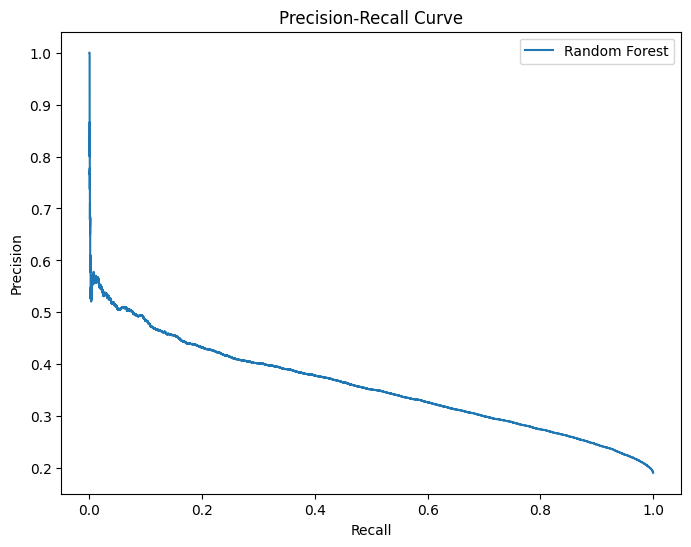

In [20]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_balanced_subsample)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

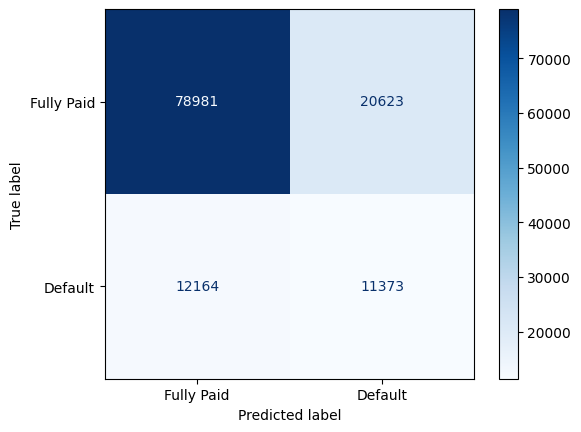

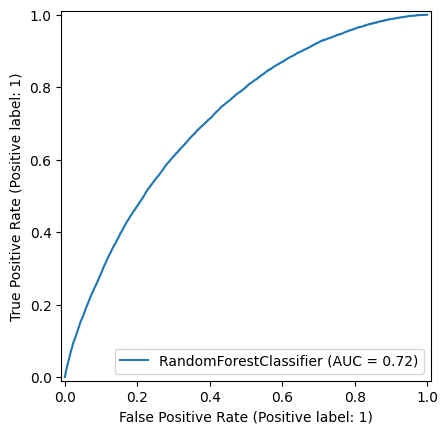

In [22]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_best_balanced_subsample, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(rf_best_balanced_subsample, X_test, y_test)

In [23]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_rc_balanced_subsample)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.27614675140023454

# CLEANED DATA ONLY

In [2]:
df_train = pd.read_csv("../data/nptrain.csv")

In [3]:
df_test = pd.read_csv("../data/nptest.csv")

In [5]:
from IPython.display import display
# Print the head of df_train vertically
display(df_train.head().T)


,0,1,2,3,4
loan_amnt,7000.0,2000.0,24000.0,15575.0,12000.0
term (months),36,36,60,60,36
int_rate,8.99,11.53,12.39,17.57,12.69
installment,222.57,65.99,538.61,391.87,402.54
sub_grade,B1,B5,C1,D2,C2
emp_length,10.0,3.0,10.0,5.0,1.0
home_ownership,RENT,RENT,MORTGAGE,MORTGAGE,RENT
annual_inc,154000.0,41600.0,120000.0,62000.0,36000.0
verification_status,Source Verified,Not Verified,Source Verified,Source Verified,Source Verified
issue_d,Jul-2016,Jun-2015,Jan-2015,Jan-2014,Feb-2015


### Converting categorical data to numeric features

In [6]:
df_train.drop('issue_d', axis=1, inplace=True)
df_test.drop('issue_d', axis=1, inplace=True)
df_train.drop('initial_list_status', axis=1, inplace=True)
df_test.drop('initial_list_status', axis=1, inplace=True)

In [7]:
columns_to_encode = ['sub_grade', 'home_ownership','verification_status','purpose','application_type']

In [8]:
# One-hot encoding 
df_train = pd.get_dummies(df_train, columns=columns_to_encode)
df_test = pd.get_dummies(df_test, columns=columns_to_encode)

In [9]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
df_train['Label'] = df_train[target_column].map(class_mapping)
df_test['Label'] = df_test[target_column].map(class_mapping)

In [10]:
print(df_train.shape)
print(df_train['Label'].value_counts(normalize=True) * 100)
print(df_test.shape)
print(df_test['Label'].value_counts(normalize=True) * 100)

(228319, 76)
Label
0    80.250877
1    19.749123
Name: proportion, dtype: float64
(112456, 77)
Label
0    80.279398
1    19.720602
Name: proportion, dtype: float64


In [11]:
df_train['purpose_educational'] = False


In [12]:
train_columns = df_train.columns
test_columns = df_test.columns

if set(train_columns) == set(test_columns):
    print("All columns match.")
else:
    print("Columns do not match.")


All columns match.


In [13]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,emp_length,annual_inc,loan_status,dti,earliest_cr_line,open_acc,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_DIRECT_PAY,application_type_INDIVIDUAL,application_type_JOINT,Label
0,1300.0,36,15.61,45.46,4.0,34000.0,Fully Paid,30.39,1999,8,...,False,False,False,False,True,False,False,True,False,0
1,12000.0,36,11.14,393.67,3.0,46000.0,Fully Paid,16.72,1990,17,...,False,False,False,False,False,False,False,True,False,0
2,13200.0,36,12.85,443.81,10.0,85000.0,Fully Paid,6.89,1999,11,...,False,False,False,False,False,False,False,True,False,0
3,15000.0,36,17.77,540.56,10.0,55000.0,Fully Paid,21.27,1998,10,...,False,False,False,False,False,False,False,True,False,0
4,7400.0,36,10.15,239.30,10.0,54000.0,Fully Paid,10.02,2003,19,...,False,False,False,False,False,False,False,True,False,0


In [14]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [15]:
X_train = df_train.drop(['Label','loan_status'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label','loan_status'], axis=1)
y_test = df_test['Label']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Basic, Basic tuning, Balanced tuning

### Random Forest Model

In [16]:
rf_base = RandomForestClassifier(random_state=42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_pred_base = rf_base.predict(X_test)

y_probs = rf_base.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred_base, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.999978      1.000000  0.999982       0.999989       0.999982
recall          1.000000      0.999911  0.999982       0.999956       0.999982
f1-score        0.999989      0.999956  0.999982       0.999972       0.999982
support    183228.000000  45091.000000  0.999982  228319.000000  228319.000000
_________________
Confusion Matrix: 
 [[183228      0]
 [     4  45087]]

Test Result:
Accuracy Score: 88.36%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.877580      0.944206  0.883643       0.910893       0.890719
recall         0.993675      0.435722  0.883643       0.714698       0.883643
f1-score       0.932026      0.596279  0.883643       0.764153       0.865815
support    90279.000000  22177.000000  0.883643  112456.000000 

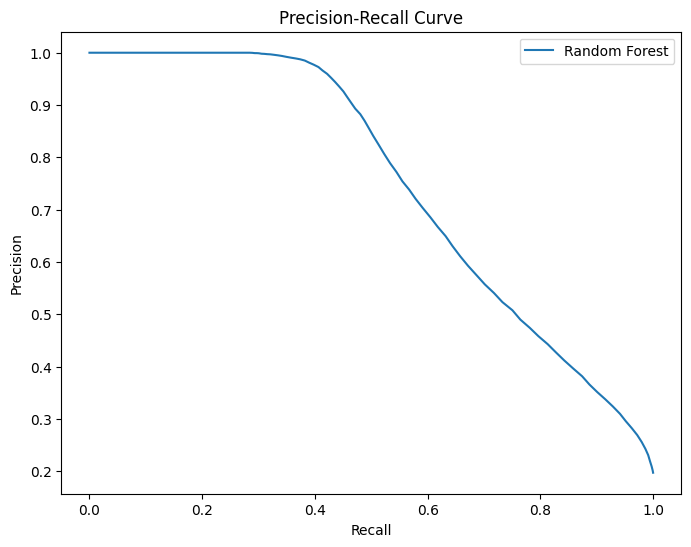

In [17]:
precision, recall, _ = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [18]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.4293968561982162

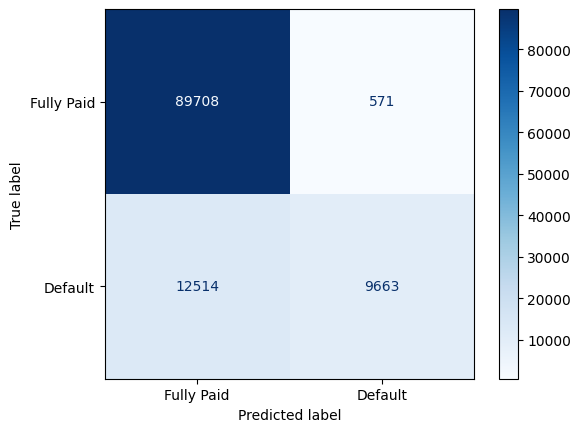

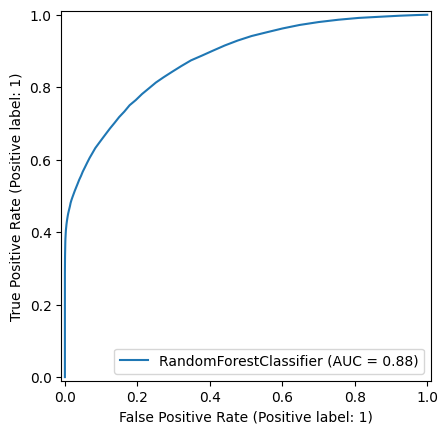

In [19]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(rf_base, X_test, y_test)

In [20]:
auprc_base = average_precision_score(y_test, y_probs)
print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")


Area Under the Precision-Recall Curve (AUPRC): 0.7459


# [undersampling] cleaned data

In [28]:
rus = RandomUnderSampler(random_state=42)

In [29]:
X_under, y_under = rus.fit_resample(X_train, y_train)

In [31]:
print(X_under.shape)
print(y_under.shape)

(434272, 128)
(434272,)


In [33]:
print('Fully Paid:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Charged Off:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Fully Paid: 217136 / 50.0 % of the dataset
Charged Off: 217136 / 50.0 % of the dataset


In [34]:
base_rf = RandomForestClassifier(random_state=42)

In [35]:
pipeline = Pipeline([
    ('undersample', rus),
    ('classifier', base_rf)
])

In [36]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersample', RandomUnderSampler(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [37]:
y_train_pred_under = pipeline.predict(X_train)
y_pred_base_under = pipeline.predict(X_test)

y_probs_unnder = pipeline.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_under, train=True)
print_score(y_test, y_pred_base_under, train=False)

Train Result:
Accuracy Score: 78.65%
F1 Weighted Score: 80.75%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       1.000000       0.481082  0.786487  7.405411e-01  8.972828e-01
recall          0.733793       1.000000  0.786487  8.668964e-01  7.864873e-01
f1-score        0.846460       0.649636  0.786487  7.480479e-01  8.074994e-01
support    879815.000000  217136.000000  0.786487  1.096951e+06  1.096951e+06
_________________
Confusion Matrix: 
 [[645602 234213]
 [     0 217136]]

Test Result:
Accuracy Score: 63.26%
F1 Weighted Score: 67.16%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.891959      0.298251  0.632584       0.595105       0.778478
recall         0.620979      0.681693  0.632584       0.651336       0.632584
f1-score       0.732202      0.414953  0.632584       0.573577       0.671563
support    99604.

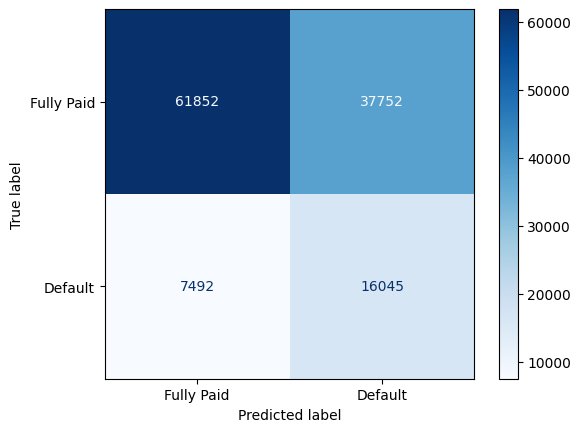

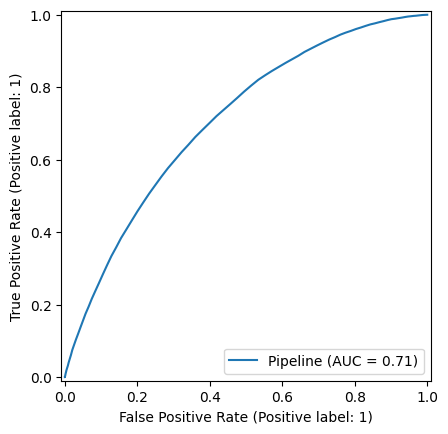

In [38]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

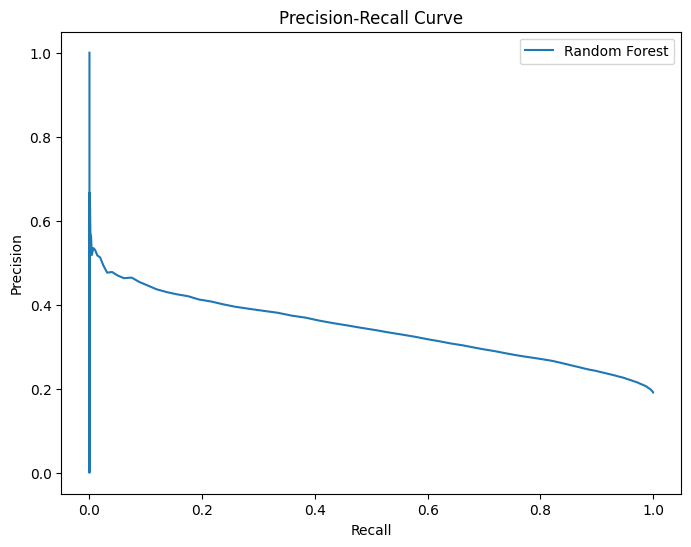

In [40]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_unnder)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [41]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.3026717312645427

### model tuning

In [43]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True]
}


random_search_under = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1')

random_search_under.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_under.best_params_)
print("Best Score:", random_search_under.best_score_)

Best Parameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': None, 'classifier__bootstrap': True}
Best Score: 0.4298191237795727


In [44]:
y_train_pred_rc_under = random_search_under.predict(X_train)
y_pred_base_rc_under = random_search_under.predict(X_test)
y_probs_rc_under = random_search_under.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_under, train=True)
print_score(y_test, y_pred_base_rc_under, train=False)

Train Result:
Accuracy Score: 70.23%
F1 Weighted Score: 73.19%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.935934       0.381640  0.702262  6.587869e-01  8.262140e-01
recall          0.674985       0.812786  0.702262  7.438853e-01  7.022620e-01
f1-score        0.784324       0.519399  0.702262  6.518615e-01  7.318835e-01
support    879815.000000  217136.000000  0.702262  1.096951e+06  1.096951e+06
_________________
Confusion Matrix: 
 [[593862 285953]
 [ 40651 176485]]

Test Result:
Accuracy Score: 63.40%
F1 Weighted Score: 67.29%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.894860      0.300924  0.633972       0.597892       0.781336
recall         0.620367      0.691549  0.633972       0.655958       0.633972
f1-score       0.732750      0.419364  0.633972       0.576057       0.672850
support    99604.

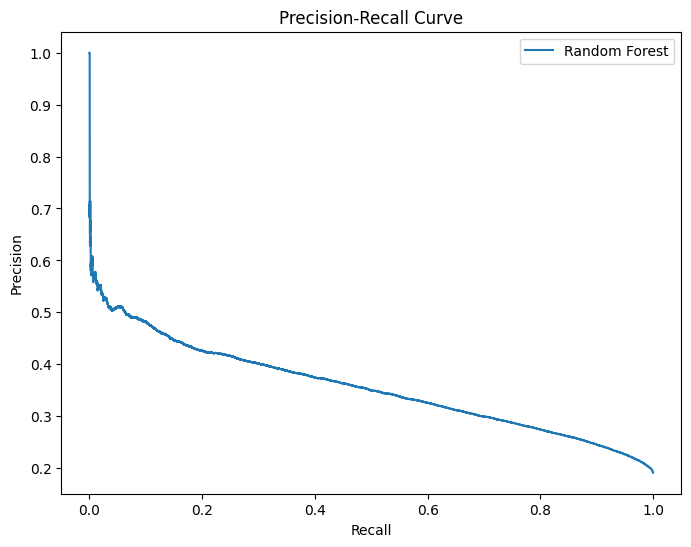

In [45]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_under)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

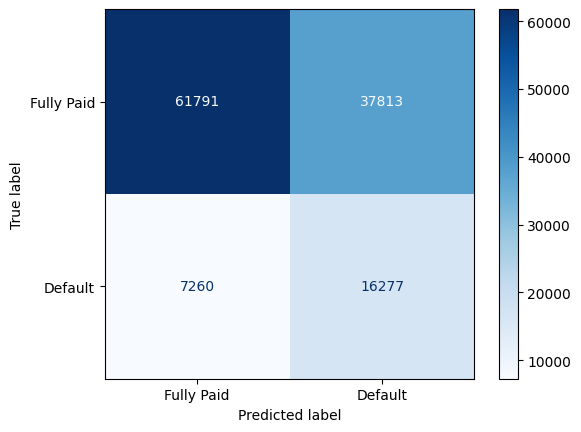

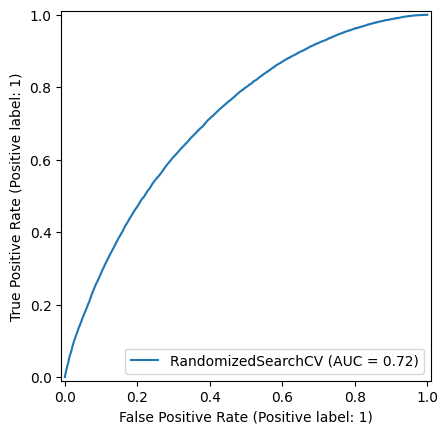

In [46]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search_under, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search_under, X_test, y_test)

In [47]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_rc_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.3119161272359067

# [undersampling] preprocessed data

In [49]:
df = pd.read_csv("data/Processed_Data.csv")

### Converting categorical data to numeric features

In [50]:
columns_to_encode = ['home_ownership','verification_status','purpose','addr_state','application_type','sub_grade']

In [51]:
# One-hot encoding 
df = pd.get_dummies(df, columns=columns_to_encode)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142240 entries, 0 to 1142239
Columns: 124 entries, loan_amnt to sub_grade_G5
dtypes: bool(108), float64(9), int64(5), object(2)
memory usage: 257.1+ MB


In [53]:
print(df['loan_status'].value_counts())


loan_status
Fully Paid     917617
Charged Off    224623
Name: count, dtype: int64


### Train/Test Split

In [54]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_11208\3004380484.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['issue_d'] = pd.to_datetime(df['issue_d'])


In [55]:
unique_issue_dates = df['issue_d'].unique()
sorted_unique_issue_dates = pd.Series(unique_issue_dates).sort_values()
print(sorted_unique_issue_dates)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


In [56]:
df_train = df.loc[df['issue_d'] <  df['issue_d'].quantile(0.9)]
df_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.9)]

In [57]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
df_train['Label'] = df_train[target_column].map(class_mapping)
df_test['Label'] = df_test[target_column].map(class_mapping)

C:\Users\winyan\AppData\Local\Temp\ipykernel_11208\1921503662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Label'] = df_train[target_column].map(class_mapping)
C:\Users\winyan\AppData\Local\Temp\ipykernel_11208\1921503662.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Label'] = df_test[target_column].map(class_mapping)


In [58]:
print(df_train.shape)
print(df_train['Label'].value_counts(normalize=True) * 100)
print(df_test.shape)
print(df_test['Label'].value_counts(normalize=True) * 100)

(1015112, 125)
Label
0    80.31104
1    19.68896
Name: proportion, dtype: float64
(127128, 125)
Label
0    80.52514
1    19.47486
Name: proportion, dtype: float64


In [59]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,annual_inc,issue_d,loan_status,dti,earliest_cr_line,open_acc,...,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,Label
328576,3000.0,36,7.34,93.10,52000.0,2018-03-01,Fully Paid,0.58,1998,7,...,False,False,False,False,False,False,False,False,False,0
328577,5000.0,36,11.98,166.03,55000.0,2018-03-01,Fully Paid,14.18,2001,14,...,False,False,False,False,False,False,False,False,False,0
328578,7000.0,36,11.98,232.44,40000.0,2018-03-01,Fully Paid,20.25,2007,13,...,False,False,False,False,False,False,False,False,False,0
328579,30000.0,36,21.85,1143.39,57000.0,2018-03-01,Fully Paid,27.58,2000,11,...,False,False,False,False,False,False,False,False,False,0
328580,21000.0,60,20.39,560.94,85000.0,2018-03-01,Fully Paid,15.76,2008,15,...,False,False,False,False,False,False,False,False,False,0


### Random Forest Model

In [60]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [61]:
X_train = df_train.drop(['Label', 'issue_d','loan_status'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label', 'issue_d','loan_status'], axis=1)
y_test = df_test['Label']

In [62]:
rus = RandomUnderSampler(random_state=42)

In [63]:
X_under, y_under = rus.fit_resample(X_train, y_train)

In [64]:
print(X_under.shape)
print(y_under.shape)

(399730, 122)
(399730,)


In [65]:
print('Fully Paid:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Charged Off:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Fully Paid: 199865 / 50.0 % of the dataset
Charged Off: 199865 / 50.0 % of the dataset


In [66]:
base_rf = RandomForestClassifier(random_state=42)

In [67]:
pipeline = Pipeline([
    ('undersample', rus),
    ('classifier', base_rf)
])

In [68]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersample', RandomUnderSampler(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [69]:
y_train_pred_under = pipeline.predict(X_train)
y_pred_base_under = pipeline.predict(X_test)

y_probs_unnder = pipeline.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_under, train=True)
print_score(y_test, y_pred_base_under, train=False)

Train Result:
Accuracy Score: 78.52%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       1.000000       0.478236   0.78519  7.391182e-01  8.972702e-01
recall          0.732528       1.000000   0.78519  8.662638e-01  7.851902e-01
f1-score        0.845617       0.647036   0.78519  7.463268e-01  8.065188e-01
support    815247.000000  199865.000000   0.78519  1.015112e+06  1.015112e+06
_________________
Confusion Matrix: 
 [[597191 218056]
 [     0 199865]]

Test Result:
Accuracy Score: 64.03%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.889424      0.307279  0.640315       0.598352       0.776052
recall          0.631884      0.675176  0.640315       0.653530       0.640315
f1-score        0.738855      0.422345  0.640315       0.580600       0.677215
support    102370.000000  24758.000000  0.640315  127128.000000  

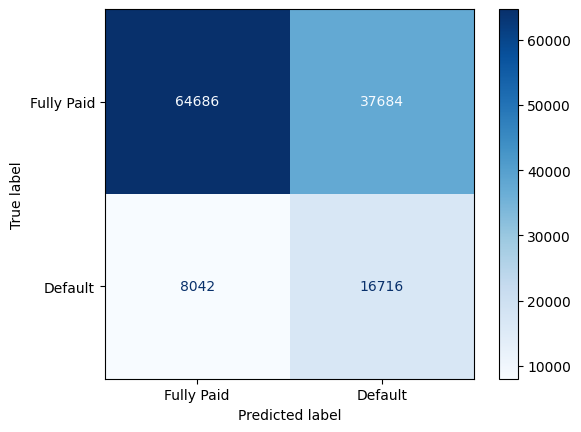

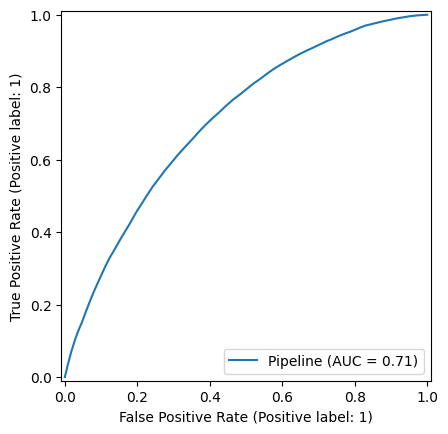

In [70]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

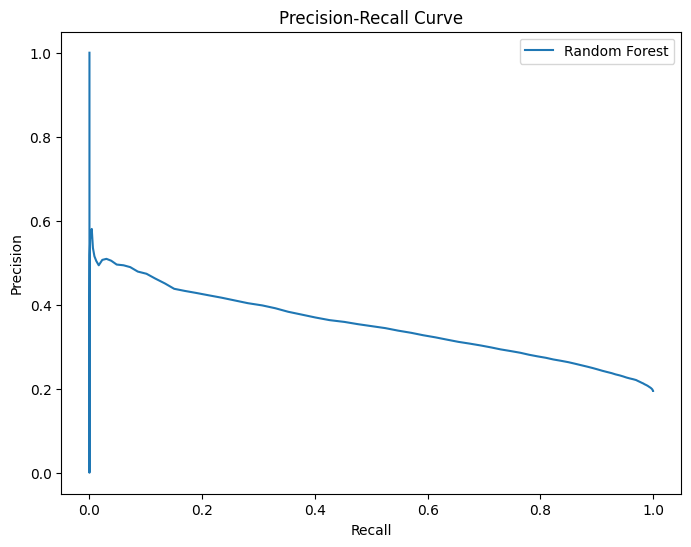

In [71]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_unnder)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [72]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.3070600418991463

### model tuning

In [73]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2, 10],
    'classifier__min_samples_leaf': [1, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True]
}


random_search_under = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1')

random_search_under.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", random_search_under.best_params_)
print("Best Score:", random_search_under.best_score_)

Best Parameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': None, 'classifier__bootstrap': True}
Best Score: 0.42758572535683315


In [74]:
y_train_pred_rc_under = random_search_under.predict(X_train)
y_pred_base_rc_under = random_search_under.predict(X_test)
y_probs_rc_under = random_search_under.predict_proba(X_test)[:, 1]

print_score(y_train, y_train_pred_rc_under, train=True)
print_score(y_test, y_pred_base_rc_under, train=False)

Train Result:
Accuracy Score: 68.58%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.924533       0.361684  0.685754  6.431085e-01  8.137139e-01
recall          0.662818       0.779311  0.685754  7.210643e-01  6.857539e-01
f1-score        0.772100       0.494067  0.685754  6.330838e-01  7.173583e-01
support    815247.000000  199865.000000  0.685754  1.015112e+06  1.015112e+06
_________________
Confusion Matrix: 
 [[540360 274887]
 [ 44108 155757]]

Test Result:
Accuracy Score: 63.86%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.892770      0.308453  0.638632       0.600611       0.778975
recall          0.626482      0.688868  0.638632       0.657675       0.638632
f1-score        0.736289      0.426109  0.638632       0.581199       0.675882
support    102370.000000  24758.000000  0.638632  127128.000000  

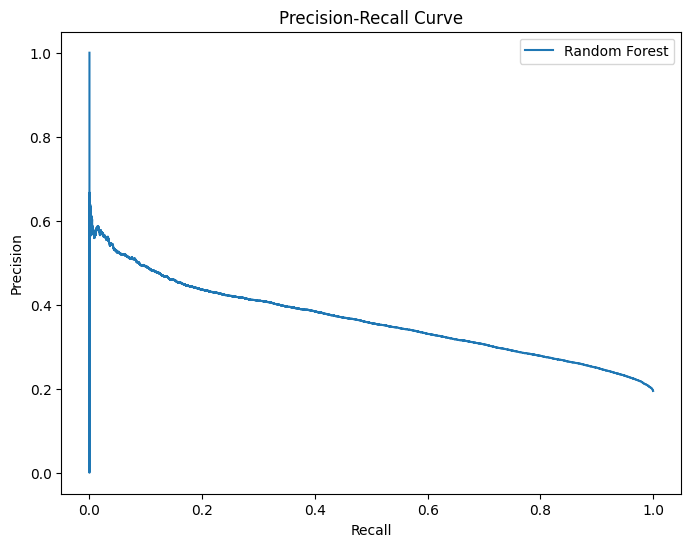

In [75]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_rc_under)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

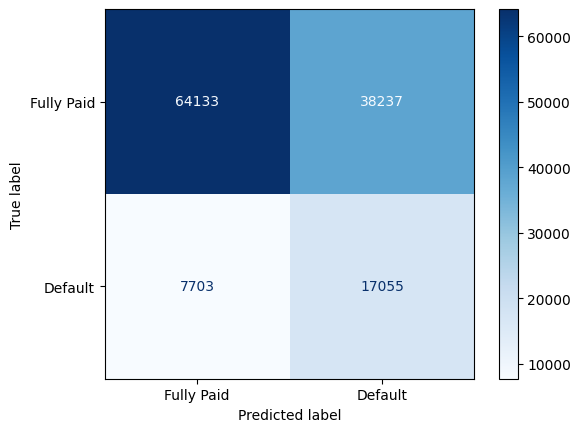

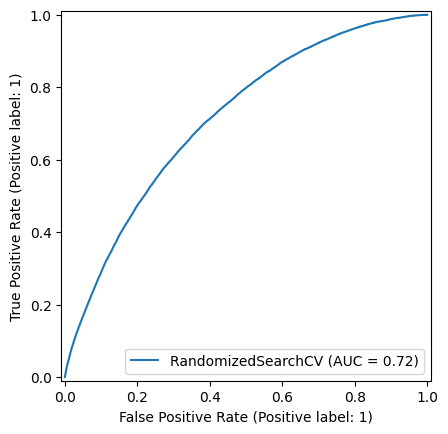

In [76]:
disp = ConfusionMatrixDisplay.from_estimator(
    random_search_under, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(random_search_under, X_test, y_test)

In [77]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_rc_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.3153506124890187

# [undersampling] xgboost

In [78]:
rus = RandomUnderSampler(random_state=42)

In [79]:
X_under, y_under = rus.fit_resample(X_train, y_train)

In [80]:
print(X_under.shape)
print(y_under.shape)

(399730, 122)
(399730,)


In [81]:
print('Fully Paid:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Charged Off:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Fully Paid: 199865 / 50.0 % of the dataset
Charged Off: 199865 / 50.0 % of the dataset


In [82]:
pip install xgboost


In [84]:
from xgboost import XGBClassifier


In [85]:
base_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [86]:
pipeline = Pipeline([
    ('undersample', rus),
    ('classifier', base_xgb)
])

In [87]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersample', RandomUnderSampler(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [88]:
# Make predictions
y_train_pred_under = pipeline.predict(X_train)
y_pred_base_under = pipeline.predict(X_test)

# Get the probability scores for the positive class
y_probs_under = pipeline.predict_proba(X_test)[:, 1]

# Assuming you have a print_score function defined as before
print_score(y_train, y_train_pred_under, train=True)
print_score(y_test, y_pred_base_under, train=False)

Train Result:
Accuracy Score: 65.98%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.897891       0.328704   0.65981  6.132976e-01  7.858242e-01
recall          0.650370       0.698316   0.65981  6.743431e-01  6.598100e-01
f1-score        0.754345       0.447001   0.65981  6.006727e-01  6.938319e-01
support    815247.000000  199865.000000   0.65981  1.015112e+06  1.015112e+06
_________________
Confusion Matrix: 
 [[530212 285035]
 [ 60296 139569]]

Test Result:
Accuracy Score: 64.06%
_________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.895399      0.311294  0.640646       0.603346       0.781645
recall          0.626981      0.697148  0.640646       0.662064       0.640646
f1-score        0.737527      0.430402  0.640646       0.583965       0.677715
support    102370.000000  24758.000000  0.640646  127128.000000  

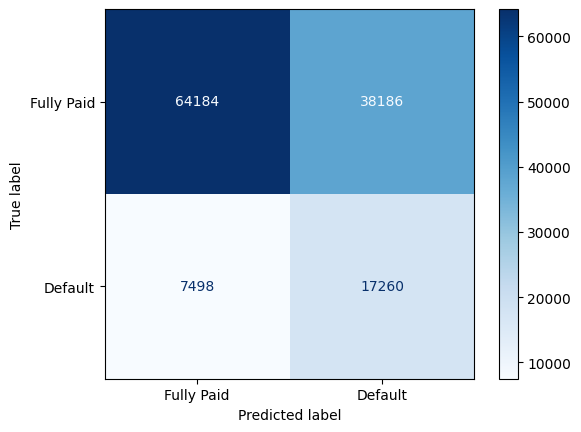

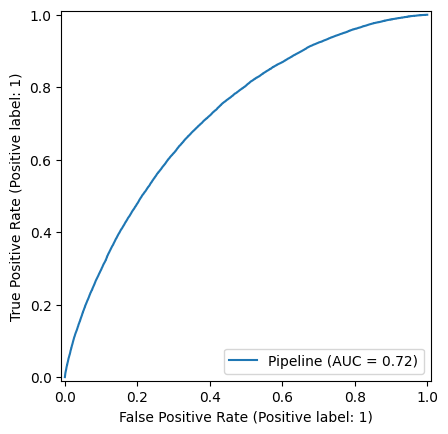

In [89]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipeline, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Fully Paid', 'Default']
)

disp = RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

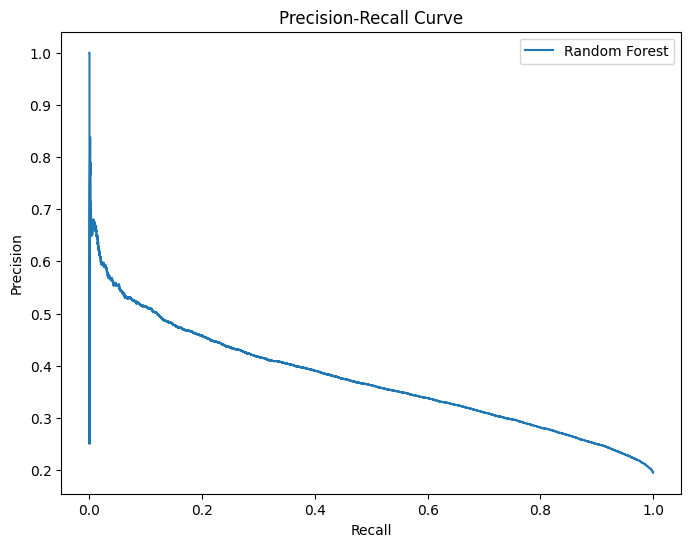

In [90]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_under)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.3026717312645427

# [old] Cleaned data, balanced training data, one hot encoding:

In [14]:
df = pd.read_csv("../data/cleaned_data.csv", encoding = "ISO-8859-1")

### Converting categorical data to numeric features

In [15]:
columns_to_encode = ['home_ownership','verification_status','purpose','addr_state','application_type','sub_grade','initial_list_status']

In [16]:
# One-hot encoding 
df = pd.get_dummies(df, columns=columns_to_encode)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220092 entries, 0 to 1220091
Columns: 130 entries, loan_amnt to initial_list_status_Whole Funded
dtypes: bool(111), float64(10), int64(7), object(2)
memory usage: 306.0+ MB


In [18]:
print(df['loan_status'].value_counts())


loan_status
Fully Paid     979419
Charged Off    240673
Name: count, dtype: int64


In [19]:
print(df.dtypes)
string_columns = df.select_dtypes(include='object').columns
if len(string_columns) > 0:
    print("The following columns have string data types:")
    for column in string_columns:
        print(column)
else:
    print("There are no string data types in the DataFrame.")


loan_amnt                                float64
term (months)                              int64
int_rate                                 float64
installment                              float64
emp_length                               float64
                                          ...   
sub_grade_G3                                bool
sub_grade_G4                                bool
sub_grade_G5                                bool
initial_list_status_Fractional Funded       bool
initial_list_status_Whole Funded            bool
Length: 130, dtype: object
The following columns have string data types:
issue_d
loan_status


### Train/Test Split

In [20]:
df_fully_paid = df[df['loan_status'] == 'Fully Paid']
df_charged_off = df[df['loan_status'] == 'Charged Off']


In [21]:
df_charged_off['issue_d'] = pd.to_datetime(df_charged_off['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_4880\2008798936.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_charged_off['issue_d'] = pd.to_datetime(df_charged_off['issue_d'])
C:\Users\winyan\AppData\Local\Temp\ipykernel_4880\2008798936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_charged_off['issue_d'] = pd.to_datetime(df_charged_off['issue_d'])


In [22]:
print(df_charged_off['issue_d'].value_counts())

issue_d
2016-03-01    9588
2015-07-01    7749
2015-10-01    7528
2015-12-01    7494
2014-10-01    6611
              ... 
2018-09-01     142
2012-03-01      90
2018-10-01      72
2018-11-01      18
2018-12-01      10
Name: count, Length: 82, dtype: int64


In [23]:
unique_issue_dates = df_charged_off['issue_d'].unique()
sorted_df_charged_off =  pd.Series(unique_issue_dates).sort_values()
print(sorted_df_charged_off)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


In [24]:
df_train_charged_off =  df_charged_off.loc[df_charged_off['issue_d'] < df_charged_off['issue_d'].quantile(0.93)]
df_test_charged_off =  df_charged_off.loc[df_charged_off['issue_d'] >= df_charged_off['issue_d'].quantile(0.93)]

In [25]:
print("Size of df_train_charged_off:", df_train_charged_off.shape)
print("Size of df_test_charged_off:", df_test_charged_off.shape)

Size of df_train_charged_off: (223598, 130)
Size of df_test_charged_off: (17075, 130)


In [26]:
df_fully_paid['issue_d'] = pd.to_datetime(df_fully_paid['issue_d'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_4880\909581260.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_fully_paid['issue_d'] = pd.to_datetime(df_fully_paid['issue_d'])
C:\Users\winyan\AppData\Local\Temp\ipykernel_4880\909581260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fully_paid['issue_d'] = pd.to_datetime(df_fully_paid['issue_d'])


In [27]:
unique_issue_dates = df_fully_paid['issue_d'].unique()
sorted_df_charged_off =  pd.Series(unique_issue_dates).sort_values()
print(sorted_df_charged_off)

72   2012-03-01
71   2012-04-01
70   2012-05-01
69   2012-06-01
68   2012-07-01
        ...    
22   2018-08-01
21   2018-09-01
44   2018-10-01
43   2018-11-01
42   2018-12-01
Length: 82, dtype: datetime64[ns]


In [30]:
df_train_fully_paid =  df_fully_paid.loc[df_fully_paid['issue_d'] < df_fully_paid['issue_d'].quantile(0.93)]
df_test_fully_paid =  df_fully_paid.loc[df_fully_paid['issue_d'] >= df_fully_paid['issue_d'].quantile(0.93)]

In [31]:
print("Size of df_train_fully_paid:", df_train_fully_paid.shape)
print("Size of df_test_fully_paid:", df_test_fully_paid.shape)

Size of df_train_fully_paid: (901673, 130)
Size of df_test_fully_paid: (77746, 130)


In [32]:
df_train_fully_paid_resize = df_train_fully_paid.sample(n=223598, random_state=42)
df_test_fully_paid_resize = df_test_fully_paid.sample(n=68300, random_state=42)

In [33]:
print("Size of df_train_fully_paid_resize:", df_train_fully_paid_resize.shape)
print("Size of df_test_fully_paid_resize:", df_test_fully_paid_resize.shape)

Size of df_train_fully_paid_resize: (223598, 130)
Size of df_test_fully_paid_resize: (68300, 130)


In [34]:
df_train = pd.concat([df_train_fully_paid_resize, df_train_charged_off])
df_test = pd.concat([df_test_fully_paid_resize, df_test_charged_off])

In [35]:
print("Size of df_train:", df_train.shape)
print("Size of df_test:", df_test.shape)

Size of df_train: (447196, 130)
Size of df_test: (85375, 130)


In [36]:
print(df_train['loan_status'].value_counts(normalize=True) * 100)
print(df_test['loan_status'].value_counts(normalize=True) * 100)

loan_status
Fully Paid     50.0
Charged Off    50.0
Name: proportion, dtype: float64
loan_status
Fully Paid     80.0
Charged Off    20.0
Name: proportion, dtype: float64


In [37]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,emp_length,annual_inc,issue_d,loan_status,dti,earliest_cr_line,...,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,initial_list_status_Fractional Funded,initial_list_status_Whole Funded
381528,18000.0,36,17.09,642.56,4.0,85000.0,2017-09-01,Fully Paid,23.51,1998,...,False,False,False,False,False,False,False,False,True,False
841463,7000.0,36,10.72,228.25,7.0,65000.0,2018-11-01,Fully Paid,18.67,2012,...,False,False,False,False,False,False,False,False,False,True
858770,11200.0,36,12.61,375.28,3.0,83000.0,2018-04-01,Fully Paid,21.24,2005,...,False,False,False,False,False,False,False,False,False,True
374280,35000.0,60,9.44,734.04,2.0,160000.0,2017-09-01,Fully Paid,15.11,1994,...,False,False,False,False,False,False,False,False,False,True
855360,12650.0,60,10.41,271.34,9.0,47000.0,2018-04-01,Fully Paid,7.02,2000,...,False,False,False,False,False,False,False,False,False,True


### Random Forest Model

In [38]:
# Encode 'loan_status'
le = LabelEncoder()
df_train['loan_status_encoded'] = le.fit_transform(df_train['loan_status'])
df_test['loan_status_encoded'] = le.transform(df_test['loan_status'])

In [39]:
print(df_test['loan_status_encoded'].value_counts(normalize=True) * 100)

loan_status_encoded
1    80.0
0    20.0
Name: proportion, dtype: float64


In [40]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [41]:
X_train = df_train.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_train = df_train['loan_status_encoded']
X_test = df_test.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_test = df_test['loan_status_encoded']

rf_base = RandomForestClassifier(random_state=42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_pred_base = rf_base.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred_base, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                  0         1  accuracy  macro avg  weighted avg
precision       1.0       1.0       1.0        1.0           1.0
recall          1.0       1.0       1.0        1.0           1.0
f1-score        1.0       1.0       1.0        1.0           1.0
support    223598.0  223598.0       1.0   447196.0      447196.0
_________________
Confusion Matrix: 
 [[223598      0]
 [     0 223598]]

Test Result:
Accuracy Score: 62.51%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.307918      0.890217  0.625078      0.599068      0.773758
recall         0.701025      0.606091  0.625078      0.653558      0.625078
f1-score       0.427890      0.721178  0.625078      0.574534      0.662521
support    17075.000000  68300.000000  0.625078  85375.000000  85375.000000
_________________
Confusion Matrix: 
 [[11970  5105]
 [26904 4139

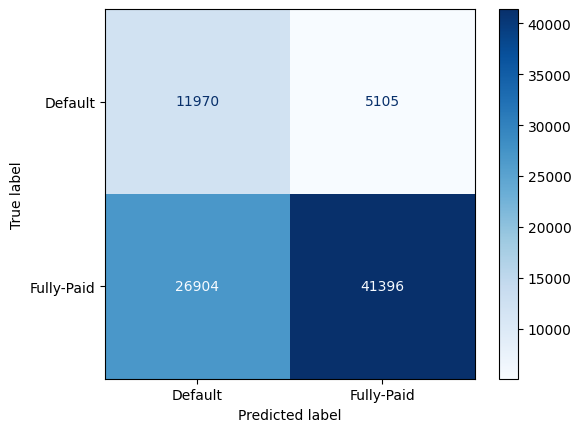

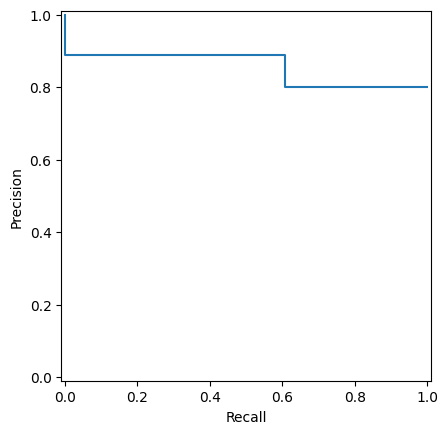

In [42]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

prec, recall, _ = precision_recall_curve(y_test, y_pred_base)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

# [old] Processed data, unbalanced data (not full set, only 60%), one hot encoding

In [2]:
df = pd.read_csv("data/Processed_Data.csv", encoding = "ISO-8859-1")

### Converting categorical data to numeric features

In [3]:
columns_to_encode = ['home_ownership','verification_status','purpose','addr_state','application_type','sub_grade']

In [4]:
# One-hot encoding 
df = pd.get_dummies(df, columns=columns_to_encode)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1142240 entries, 0 to 1142239
Columns: 124 entries, loan_amnt to sub_grade_G5
dtypes: bool(108), float64(9), int64(5), object(2)
memory usage: 257.1+ MB


In [6]:
print(df['loan_status'].value_counts())


loan_status
Fully Paid     917617
Charged Off    224623
Name: count, dtype: int64


In [7]:
print(df.dtypes)
string_columns = df.select_dtypes(include='object').columns
if len(string_columns) > 0:
    print("The following columns have string data types:")
    for column in string_columns:
        print(column)
else:
    print("There are no string data types in the DataFrame.")


loan_amnt        float64
term (months)      int64
int_rate         float64
installment      float64
annual_inc       float64
                  ...   
sub_grade_G1        bool
sub_grade_G2        bool
sub_grade_G3        bool
sub_grade_G4        bool
sub_grade_G5        bool
Length: 124, dtype: object
The following columns have string data types:
issue_d
loan_status


### Train/Test Split

In [9]:
df_sample = df.sample(frac=0.6, random_state=42)

In [11]:
df_sample['issue_d'] = pd.to_datetime(df_sample['issue_d'])

In [12]:
unique_issue_dates = df_sample['issue_d'].unique()
sorted_unique_issue_dates = pd.Series(unique_issue_dates).sort_values()
print(sorted_unique_issue_dates)

81   2012-03-01
53   2012-04-01
39   2012-05-01
10   2012-06-01
75   2012-07-01
        ...    
77   2018-08-01
50   2018-09-01
79   2018-10-01
78   2018-11-01
80   2018-12-01
Length: 82, dtype: datetime64[ns]


In [14]:
df_train = df_sample.loc[df_sample['issue_d'] <  df_sample['issue_d'].quantile(0.9)]
df_test =  df_sample.loc[df_sample['issue_d'] >= df_sample['issue_d'].quantile(0.9)]

In [15]:
print("Size of df_train:", df_train.shape)
print("Size of df_test:", df_test.shape)

Size of df_train: (608777, 124)
Size of df_test: (76567, 124)


In [16]:
print(df_train['loan_status'].value_counts(normalize=True) * 100)
print(df_test['loan_status'].value_counts(normalize=True) * 100)

loan_status
Fully Paid     80.303954
Charged Off    19.696046
Name: proportion, dtype: float64
loan_status
Fully Paid     80.49682
Charged Off    19.50318
Name: proportion, dtype: float64


In [17]:
df_test.head()

,loan_amnt,term (months),int_rate,installment,annual_inc,issue_d,loan_status,dti,earliest_cr_line,open_acc,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
1069881,12000.0,36,12.62,402.14,68000.0,2017-12-01,Fully Paid,18.50,2011,11,...,False,False,False,False,False,False,False,False,False,False
459497,30000.0,36,24.85,1190.42,112000.0,2017-06-01,Fully Paid,21.98,2001,16,...,False,False,False,False,False,False,False,False,False,False
1085587,10000.0,36,11.99,332.10,68000.0,2017-10-01,Fully Paid,25.06,2005,24,...,False,False,False,False,False,False,False,False,False,False
346408,3000.0,36,9.93,96.71,53000.0,2018-01-01,Fully Paid,5.55,2007,6,...,False,False,False,False,False,False,False,False,False,False
1090156,4600.0,36,9.44,147.23,72000.0,2017-10-01,Fully Paid,8.95,1986,8,...,False,False,False,False,False,False,False,False,False,False


### Random Forest Model

In [18]:
# Encode 'loan_status'
le = LabelEncoder()
df_train['loan_status_encoded'] = le.fit_transform(df_train['loan_status'])
df_test['loan_status_encoded'] = le.transform(df_test['loan_status'])

C:\Users\winyan\AppData\Local\Temp\ipykernel_5508\1542006363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['loan_status_encoded'] = le.fit_transform(df_train['loan_status'])
C:\Users\winyan\AppData\Local\Temp\ipykernel_5508\1542006363.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['loan_status_encoded'] = le.transform(df_test['loan_status'])


In [19]:
print(df_test['loan_status_encoded'].value_counts(normalize=True) * 100)

loan_status_encoded
1    80.49682
0    19.50318
Name: proportion, dtype: float64


In [20]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [21]:
X_train = df_train.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_train = df_train['loan_status_encoded']
X_test = df_test.drop(['loan_status', 'loan_status_encoded', 'issue_d'], axis=1)
y_test = df_test['loan_status_encoded']

rf_base = RandomForestClassifier(random_state=42)

rf_base.fit(X_train, y_train)

y_train_pred = rf_base.predict(X_train)
y_pred_base = rf_base.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_pred_base, train=False)

Train Result:
Accuracy Score: 100.00%
_________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       1.000000       0.999996  0.999997       0.999998   
recall          0.999983       1.000000  0.999997       0.999992   
f1-score        0.999992       0.999998  0.999997       0.999995   
support    119905.000000  488872.000000  0.999997  608777.000000   

            weighted avg  
precision       0.999997  
recall          0.999997  
f1-score        0.999997  
support    608777.000000  
_________________
Confusion Matrix: 
 [[119903      2]
 [     0 488872]]

Test Result:
Accuracy Score: 80.42%
_________________
CLASSIFICATION REPORT:
                      0             1  accuracy     macro avg  weighted avg
precision      0.490000      0.816164  0.804237      0.653082      0.752552
recall         0.091877      0.976831  0.804237      0.534354      0.804237
f1-score       0.154740      0.889299  0.804237      0.522019     

Area under Precision-Recall Curve: 0.9058228559338288


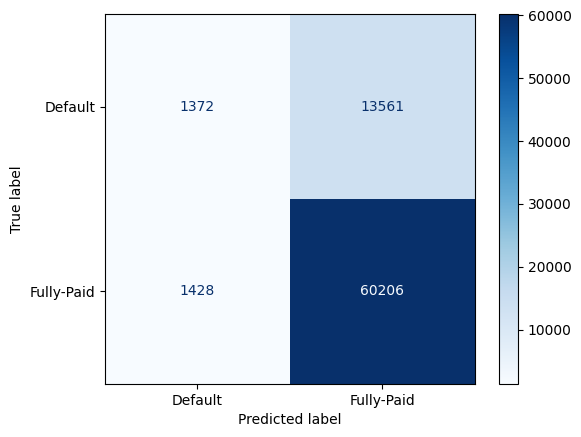

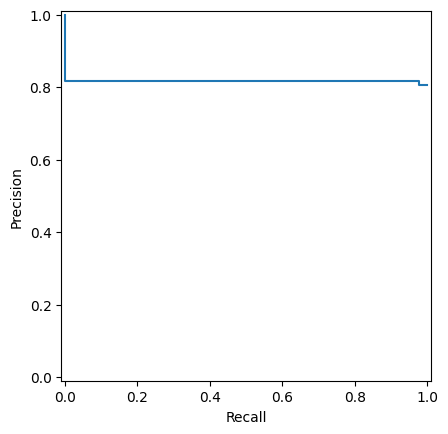

In [24]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_base, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()
area_under_curve = auc(recall, prec)
print("Area under Precision-Recall Curve:", area_under_curve)

# ignore below

In [49]:
# Get feature importance using RandomForest

importances = rf_base.feature_importances_

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print(feature_importance_df)


                      feature    importance
2                    int_rate  8.943332e-02
5                         dti  7.226320e-02
9                   revol_bal  6.620882e-02
10                 revol_util  6.481425e-02
3                 installment  6.352443e-02
..                        ...           ...
120              sub_grade_G4  1.502341e-04
30   purpose_renewable_energy  1.442068e-04
121              sub_grade_G5  1.135138e-04
15       home_ownership_OTHER  5.936359e-05
46              addr_state_IA  4.495982e-07

[122 rows x 2 columns]


### CV and RFE

In [36]:
# Initialize the RFECV model with cross-validation
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=42),
    step=1,
    cv=StratifiedKFold(5),
    scoring='accuracy'
)

In [37]:
rfecv.fit(X_train, y_train)


KeyboardInterrupt: 

In [ ]:
print("Optimal number of features: {}".format(rfecv.n_features_))
print("Best features: {}".format(X_train.columns[rfecv.support_]))

In [ ]:
# Select only the important features based on RFECV
X_train_selected = X_train[X_train.columns[rfecv.support_]]
X_test_selected = X_test[X_test.columns[rfecv.support_]]

# Train a new model on only the selected features
rf_optimized = RandomForestClassifier(random_state=42)
rf_optimized.fit(X_train_selected, y_train)

# Predict and evaluate the model
y_pred_optimized = rf_optimized.predict(X_test_selected)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Model Accuracy: {accuracy_optimized}")

In [41]:
# Define a grid of parameters to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# Evaluate the tuned model
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Tuned Model Accuracy: {accuracy_best}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 